Task 1: Modeling for predicting hospitalization at ED triage

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
cd /content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-

/content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-


In [37]:
cd Benchmark_scripts/

/content/drive/MyDrive/ED_Prediction_Fairness_Benchmark-/Benchmark_scripts


In [38]:
import sys
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')
# append original data path helpers.py
sys.path.append('/content/drive/My Drive/MIMIC_IV_ED')

from helpers import PlotROCCurve

df_train = pd.read_csv('/content/drive/MyDrive/MIMIC_IV_ED/processed_data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/MIMIC_IV_ED/processed_data/test.csv')
confidence_interval = 95
random_seed=0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
random.seed(random_seed)
np.random.seed(random_seed)

In [40]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,0,1,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0


1. Task-specific filter: No task-specific exclusion needed

In [41]:
print('training size =', len(df_train), ', testing size =', len(df_test))

training size = 359043 , testing size = 89761


2. Variable Selection

In [42]:
variable = ["age", "gender",

            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d",
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d",

            "triage_temperature", "triage_heartrate", "triage_resprate",
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",

            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough",
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",

            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia",
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1",
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2",
            "cci_Cancer2", "cci_HIV",

            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy",
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_hospitalization"



In [43]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [44]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [45]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [46]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.9157338142547674 : 1


3. Modeling Script

In [47]:
!pip install fairlearn

In [48]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.utils import resample
import numpy as np
import pandas as pd

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else np.nan

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp) if (fn + tp) > 0 else np.nan

def bootstrap_fairness_metric_ci(df, y_true_col, y_pred_col, y_score_col, group_col, B=1000, random_seed=42):
    group_vals = df[group_col].unique()

    metric_funcs = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score,
        'specificity': specificity_score,
        'fpr': false_positive_rate,
        'fnr': false_negative_rate,
        'selection_rate': selection_rate
    }

    results = {metric: {g: [] for g in group_vals} for metric in metric_funcs}
    results['auc'] = {g: [] for g in group_vals}

    for b in range(B):
        sample = resample(df, replace=True, random_state=random_seed + b)

        mf = MetricFrame(
            metrics=metric_funcs,
            y_true=sample[y_true_col],
            y_pred=sample[y_pred_col],
            sensitive_features=sample[group_col]
        )

        for metric in metric_funcs:
            for g in group_vals:
                results[metric][g].append(mf.by_group[metric][g])

        for g in group_vals:
            mask = sample[group_col] == g
            auc_val = roc_auc_score(sample.loc[mask, y_true_col], sample.loc[mask, y_score_col])
            results['auc'][g].append(auc_val)

    rows = []
    for metric in results:
        for g in group_vals:
            values = results[metric][g]
            rows.append({
                'Metric': metric,
                'Group': g,
                'Mean': np.mean(values),
                'CI_lower': np.percentile(values, 2.5),
                'CI_upper': np.percentile(values, 97.5)
            })

    return pd.DataFrame(rows)

In [49]:
# Containers for all results
result_list = []

Logistic Regression (with standardization):
AUC: 0.8118096883135669
AUPRC: 0.7811505905953013
Sensitivity: 0.7593552908199019
Specificity: 0.7112095589018339
Score thresold: 0.4423043094942625
2.5 97.5


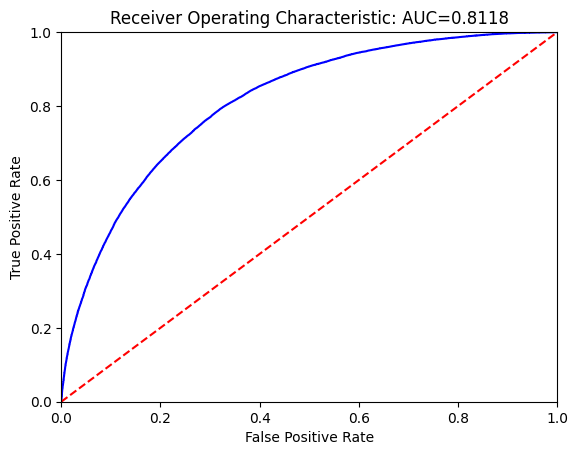

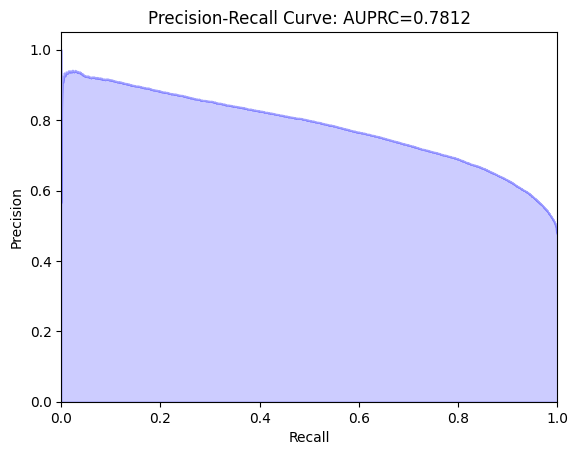

Accuracy: 0.734105012199062


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle
import time

# Step 1: 定义需要标准化的变量
vars_to_standardize = [
    "age", "n_ed_30d", "n_ed_90d", "n_ed_365d",
    "n_hosp_30d", "n_hosp_90d", "n_hosp_365d",
    "n_icu_30d", "n_icu_90d", "n_icu_365d",
    "triage_temperature", "triage_heartrate",
    "triage_resprate", "triage_o2sat",
    "triage_sbp", "triage_dbp", "triage_pain"
]

# Step 2: 标准化训练集与测试集
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[vars_to_standardize] = scaler.fit_transform(X_train[vars_to_standardize])
X_test_scaled[vars_to_standardize] = scaler.transform(X_test[vars_to_standardize])

# Step 3: 模型训练
print("Logistic Regression (with standardization):")
logreg = LogisticRegression(random_state=random_seed, max_iter=1000)
start = time.time()
logreg.fit(X_train_scaled, y_train)
runtime = time.time() - start

# Step 4: 模型保存
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)

# Step 5: 模型预测 + 评估
probs = logreg.predict_proba(X_test_scaled)
y_pred = (probs[:, 1] >= 0.442).astype(int)

result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)
# 计算 Accuracy
acc = accuracy_score(y_test, y_pred)

results = ["LR"]
results.extend(result)
results.append(runtime)
results.append(acc)

print("Accuracy:", acc)

In [ ]:
result_list = [results]

result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df['Accuracy'] = result_df['accuracy']

formatted_result_df


,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime,Accuracy
0,LR,0.442,0.812 (0.809-0.814),0.781 (0.777-0.785),0.759 (0.736-0.762),0.711 (0.71-0.732),10.643,0.734


In [ ]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[:, 1][valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== Logistic Regression Per-Gender Metrics(Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== Logistic Regression Per-Gender Metrics(Mean + 95% CI) ===

Female:
accuracy         Mean = 0.73722, CI = (0.73341, 0.74114)
precision        Mean = 0.69721, CI = (0.69153, 0.70277)
recall           Mean = 0.72497, CI = (0.71892, 0.73063)
f1               Mean = 0.71082, CI = (0.70621, 0.71543)
specificity      Mean = 0.74706, CI = (0.74199, 0.75194)
fpr              Mean = 0.25294, CI = (0.24806, 0.25801)
fnr              Mean = 0.27503, CI = (0.26937, 0.28108)
selection_rate   Mean = 0.46322, CI = (0.45891, 0.46733)
auc              Mean = 0.81370, CI = (0.80986, 0.81747)

Male:
accuracy         Mean = 0.73047, CI = (0.72625, 0.73465)
precision        Mean = 0.71340, CI = (0.70751, 0.71879)
recall           Mean = 0.79501, CI = (0.78977, 0.80067)
f1               Mean = 0.75199, CI = (0.74754, 0.75643)
specificity      Mean = 0.66222, CI = (0.65530, 0.66855)
fpr              Mean = 0.33778, CI = (0.33145, 0.34470)
fnr              Mean = 0.20499, CI = (0.19933, 0.21023)
selection

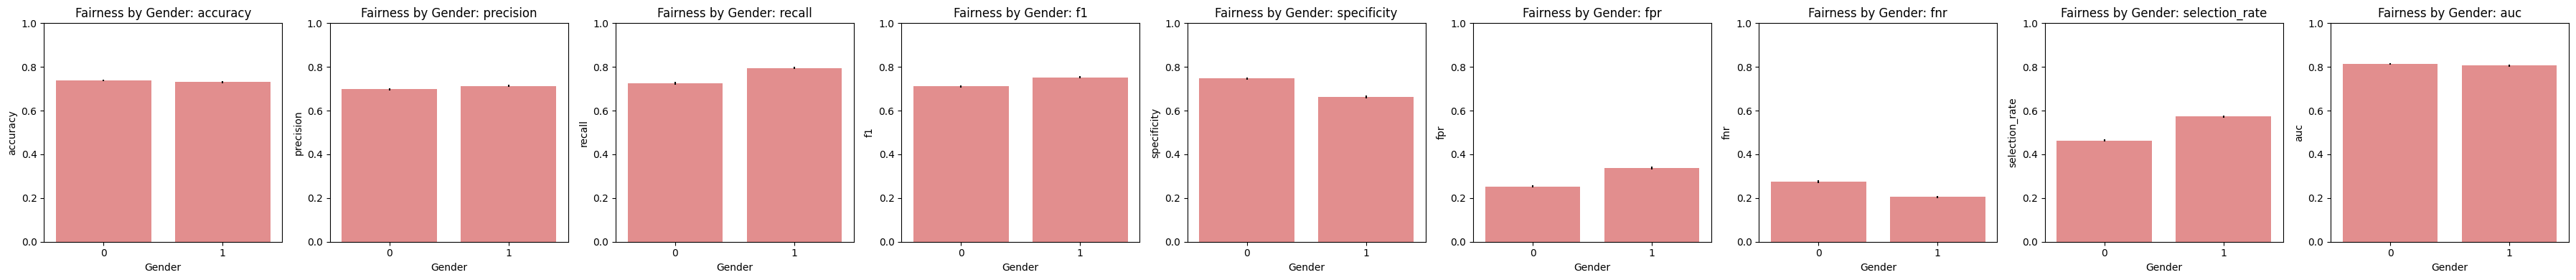

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<ipython-input-19-1030829093>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


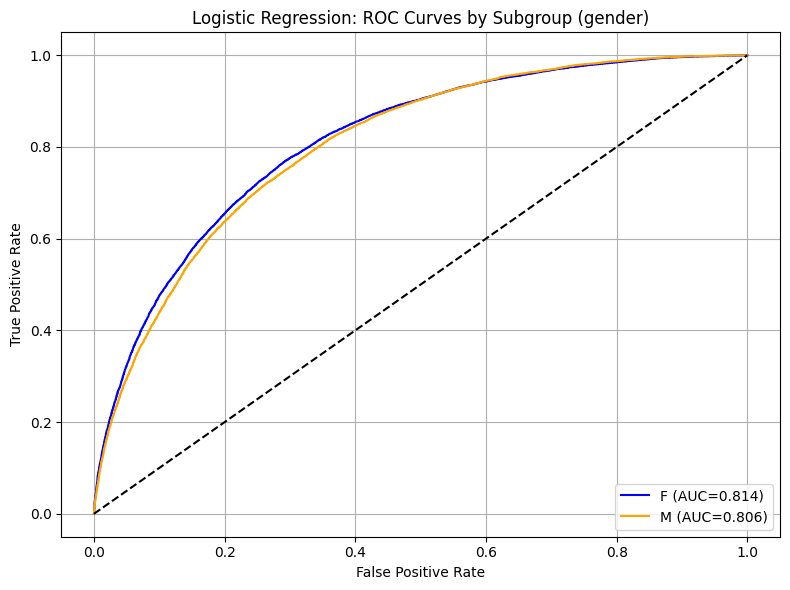

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('Logistic Regression: ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = probs[:, 1][valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== Logistic Regression Per-Ethnicity Metrics(Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Logistic Regression Per-Ethnicity Metrics(Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.67527, CI = (0.65515, 0.69649)
precision        Mean = 0.85475, CI = (0.83442, 0.87377)
recall           Mean = 0.70874, CI = (0.68591, 0.73228)
f1               Mean = 0.77486, CI = (0.75788, 0.79192)
specificity      Mean = 0.55033, CI = (0.49752, 0.60388)
fpr              Mean = 0.44967, CI = (0.39612, 0.50248)
fnr              Mean = 0.29126, CI = (0.26772, 0.31409)
selection_rate   Mean = 0.65400, CI = (0.63249, 0.67688)
auc              Mean = 0.68151, CI = (0.65045, 0.71052)

Black or African American:
accuracy         Mean = 0.68152, CI = (0.67303, 0.68975)
precision        Mean = 0.75603, CI = (0.74658, 0.76583)
recall           Mean = 0.70966, CI = (0.70001, 0.71948)
f1               Mean = 0.73210, CI = (0.72412, 0.74003)
specificity      Mean = 0.63691, CI = (0.62379, 0.64986)
fpr              Mean = 0.36309, CI = (0.35014, 0.37621)
fnr              Mean = 0.29034, CI = (0.28

<ipython-input-21-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-21-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-21-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-21-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-21-1104984648>:28: UserWarning: set_ticklabels() should only be u

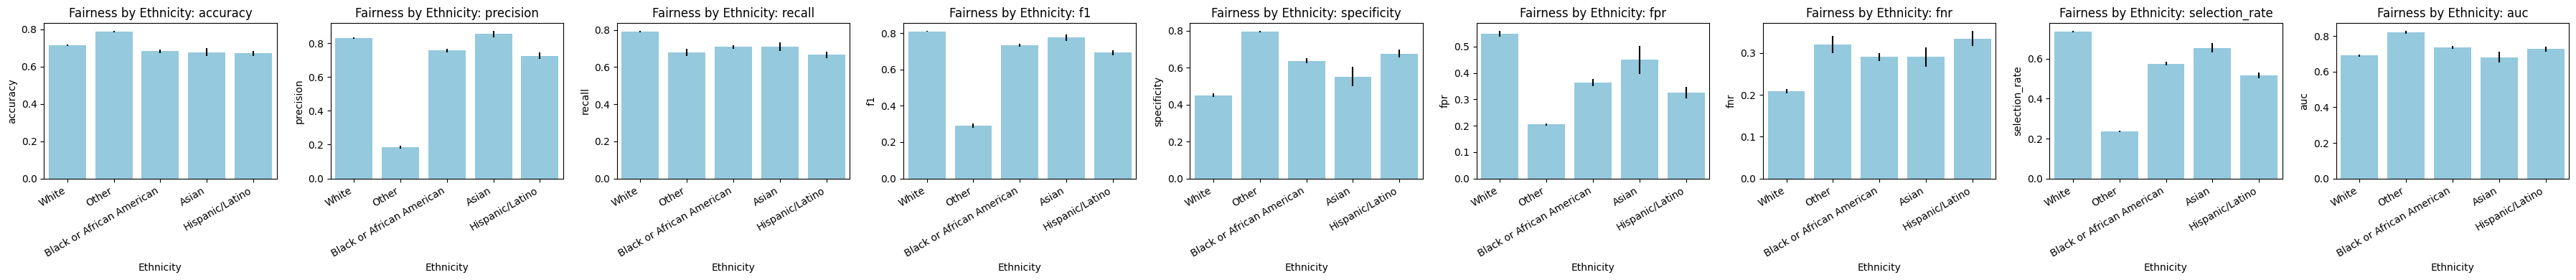

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

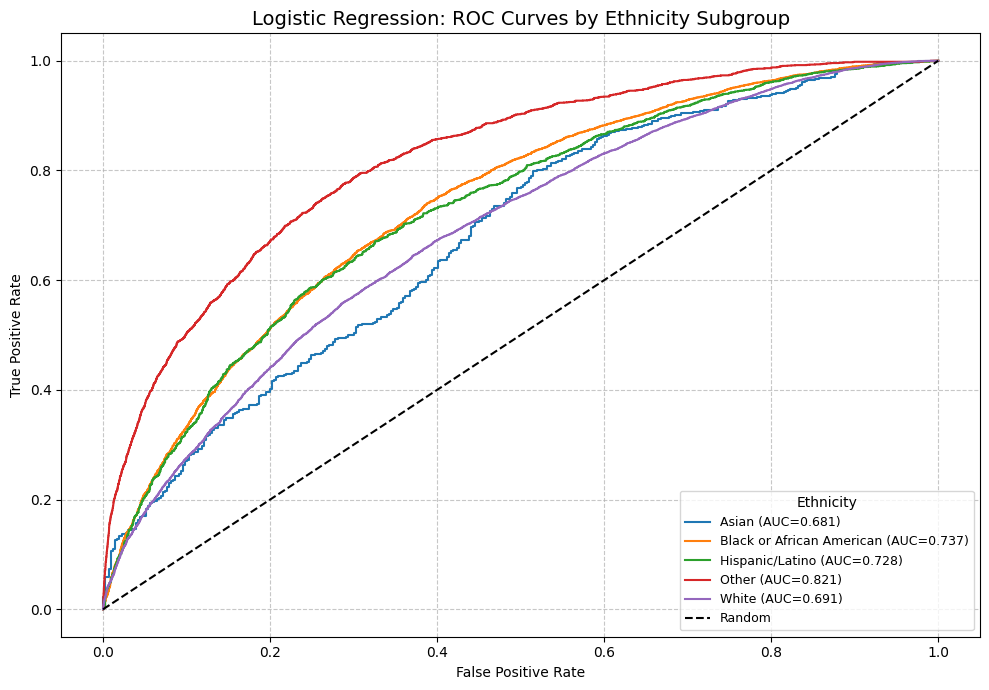

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('Logistic Regression: ROC Curves by Ethnicity Subgroup', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = probs[:, 1][valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== Logistic Regression Per-Age Group Metrics(Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Logistic Regression Per-Age Group Metrics(Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.78273, CI = (0.77432, 0.79083)
precision        Mean = 0.55908, CI = (0.52996, 0.58813)
recall           Mean = 0.27134, CI = (0.25306, 0.29109)
f1               Mean = 0.36529, CI = (0.34498, 0.38682)
specificity      Mean = 0.93591, CI = (0.93037, 0.94144)
fpr              Mean = 0.06409, CI = (0.05856, 0.06963)
fnr              Mean = 0.72866, CI = (0.70891, 0.74694)
selection_rate   Mean = 0.11186, CI = (0.10573, 0.11854)
auc              Mean = 0.78475, CI = (0.77427, 0.79440)

Age Group 25–34:
accuracy         Mean = 0.76171, CI = (0.75388, 0.76894)
precision        Mean = 0.59954, CI = (0.58085, 0.61746)
recall           Mean = 0.42970, CI = (0.41448, 0.44565)
f1               Mean = 0.50056, CI = (0.48637, 0.51471)
specificity      Mean = 0.88951, CI = (0.88294, 0.89544)
fpr              Mean = 0.11049, CI = (0.10456, 0.11706)
fnr              Mean = 0.57030, CI = (0.55

<ipython-input-24-582225410>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-24-582225410>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-24-582225410>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-24-582225410>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-24-582225410>:32: UserWarning: set_ticklabels() should only be used w

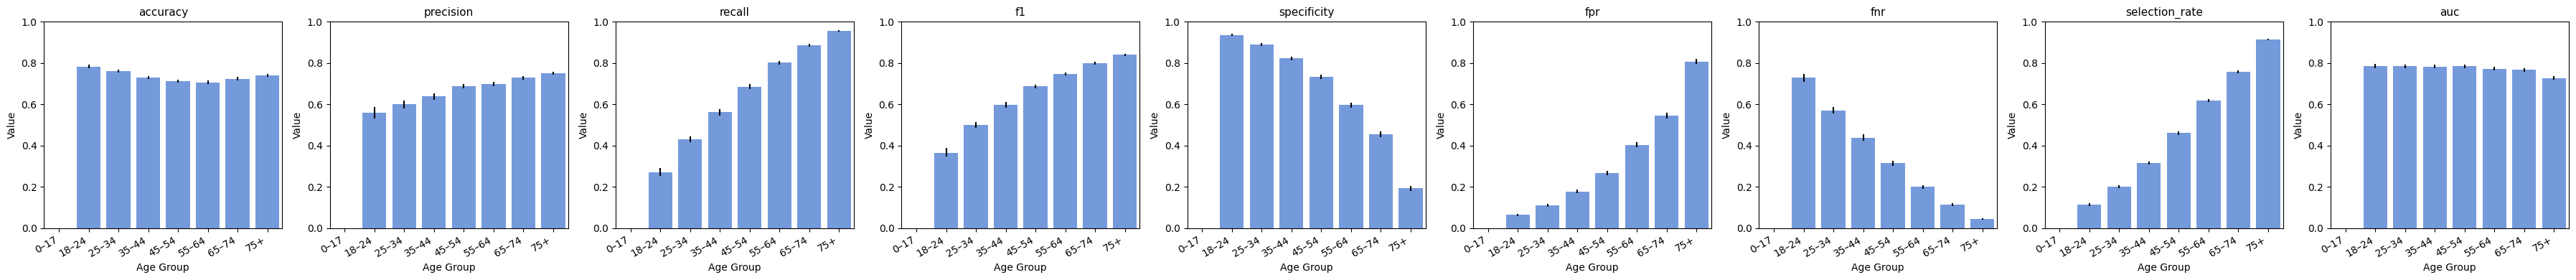

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


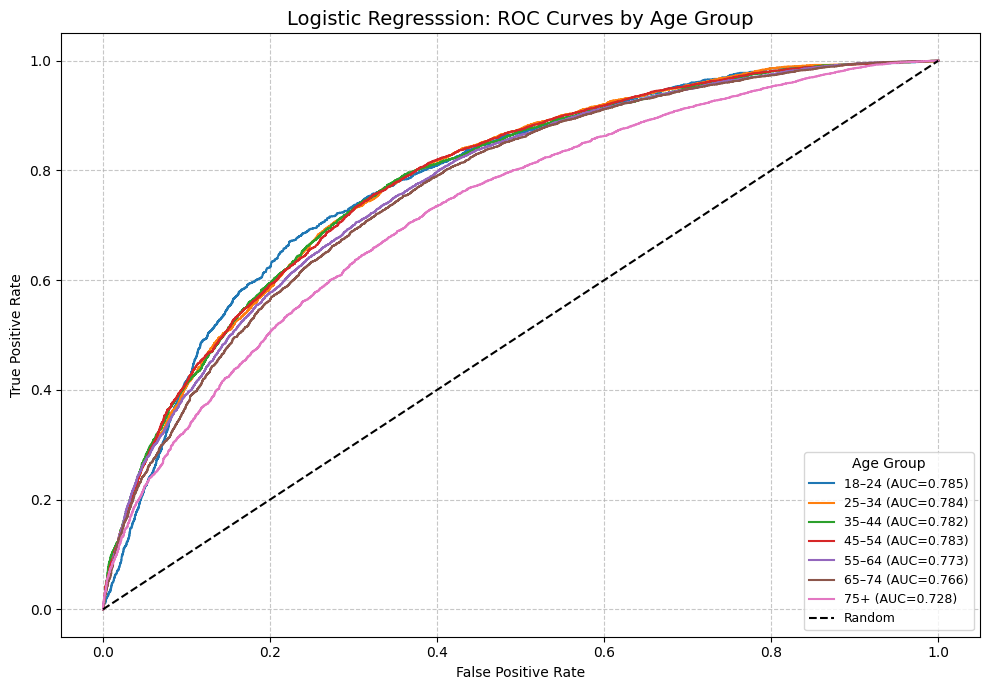

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('Logistic Regresssion: ROC Curves by Age Group', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

RandomForest:
Training time: 125.84206342697144 seconds
AUC: 0.8197233861395832
AUPRC: 0.7868599403365448
Sensitivity: 0.7512497080121467
Specificity: 0.7376839683925795
Score thresold: 0.498
2.5 97.5


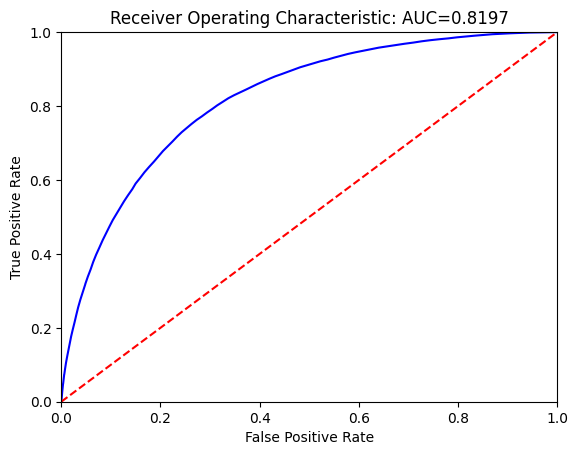

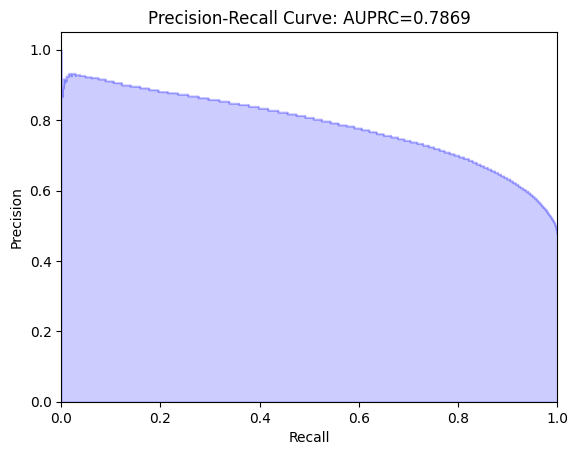

[0.12415777 0.01288518 0.00756089 0.0114081  0.02209293 0.0061509
 0.01438601 0.0282988  0.00076611 0.00179287 0.0050363  0.07793399
 0.08445447 0.04024207 0.04737683 0.08594139 0.08243049 0.04951439
 0.11291072 0.00698566 0.00896571 0.0049689  0.0005434  0.00422316
 0.00278781 0.00383114 0.00421012 0.00342267 0.00404684 0.0034602
 0.00550603 0.00292713 0.00303391 0.00143548 0.0062083  0.00216886
 0.00148508 0.00383176 0.00593042 0.00347398 0.0012109  0.0061037
 0.00442188 0.00137822 0.00203973 0.00108738 0.00810434 0.00271293
 0.00243687 0.0044548  0.01010546 0.00444447 0.00424056 0.00097929
 0.00370756 0.00479276 0.00347519 0.01164388 0.00114055 0.00336456
 0.00472488 0.00419452 0.00277252 0.00767628]


In [ ]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

from sklearn.metrics import accuracy_score

y_pred_rf = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_rf)
results.append(acc)

In [ ]:
 result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df['Accuracy'] = result_df['accuracy']

formatted_result_df


,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime,Accuracy
0,RF,0.498,0.82 (0.818-0.822),0.787 (0.784-0.79),0.751 (0.744-0.761),0.738 (0.726-0.742),123.895,0.744


In [ ]:
probs = rf.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.498).astype(int)

In [ ]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[:, 1][valid_mask]  # important for AUC
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== Random Forest Per-Gender Metrics for Sepsis (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== Random Forest Per-Gender Metrics for Sepsis (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.74534, CI = (0.74149, 0.74926)
precision        Mean = 0.71212, CI = (0.70615, 0.71822)
recall           Mean = 0.71903, CI = (0.71302, 0.72513)
f1               Mean = 0.71556, CI = (0.71085, 0.72014)
specificity      Mean = 0.76648, CI = (0.76140, 0.77143)
fpr              Mean = 0.23352, CI = (0.22857, 0.23860)
fnr              Mean = 0.28097, CI = (0.27487, 0.28698)
selection_rate   Mean = 0.44981, CI = (0.44567, 0.45399)
auc              Mean = 0.82056, CI = (0.81687, 0.82421)

Male:
accuracy         Mean = 0.74278, CI = (0.73841, 0.74685)
precision        Mean = 0.73371, CI = (0.72803, 0.73939)
recall           Mean = 0.78418, CI = (0.77918, 0.78969)
f1               Mean = 0.75810, CI = (0.75356, 0.76236)
specificity      Mean = 0.69900, CI = (0.69245, 0.70489)
fpr              Mean = 0.30100, CI = (0.29511, 0.30755)
fnr              Mean = 0.21582, CI = (0.21031, 0.22082)
sel

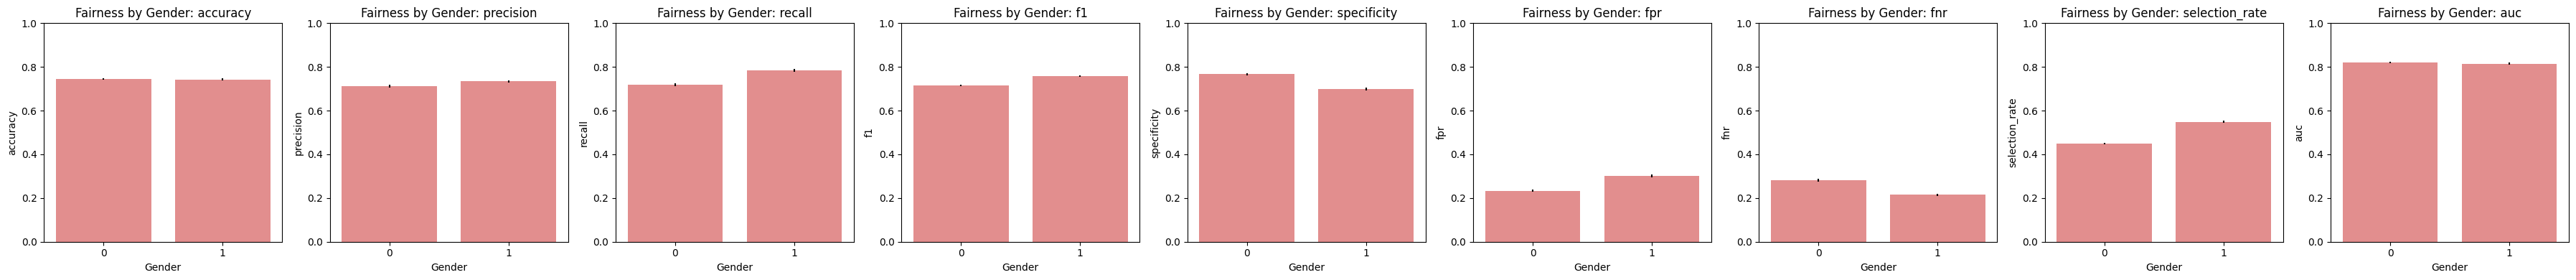

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<ipython-input-20-242715977>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


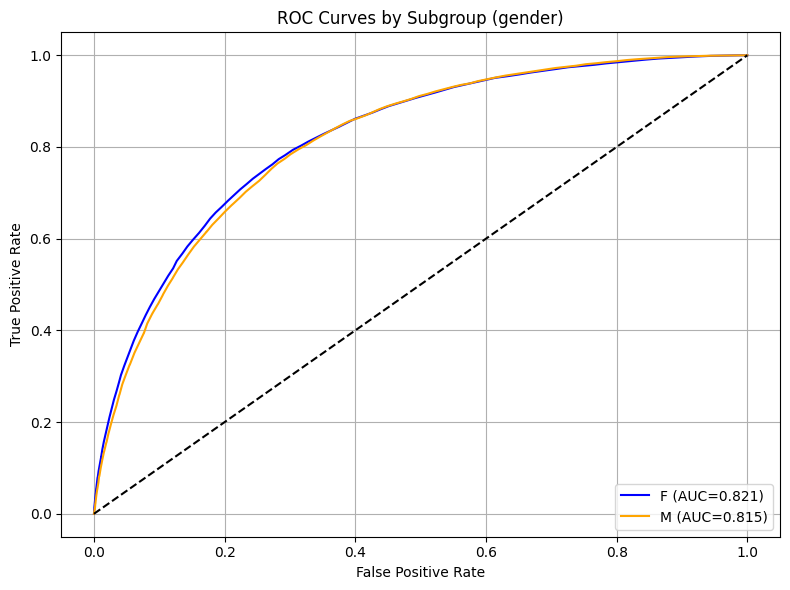

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = probs[:, 1][valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== Random Forest Per-Ethnicity Metrics (Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Random Forest Per-Ethnicity Metrics (Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.68666, CI = (0.66700, 0.70853)
precision        Mean = 0.86061, CI = (0.84119, 0.88061)
recall           Mean = 0.71922, CI = (0.69568, 0.74262)
f1               Mean = 0.78352, CI = (0.76703, 0.80099)
specificity      Mean = 0.56510, CI = (0.51392, 0.61641)
fpr              Mean = 0.43490, CI = (0.38359, 0.48608)
fnr              Mean = 0.28078, CI = (0.25738, 0.30432)
selection_rate   Mean = 0.65914, CI = (0.63758, 0.68040)
auc              Mean = 0.70262, CI = (0.67446, 0.73094)

Black or African American:
accuracy         Mean = 0.68060, CI = (0.67256, 0.68849)
precision        Mean = 0.75926, CI = (0.75016, 0.76912)
recall           Mean = 0.70160, CI = (0.69159, 0.71178)
f1               Mean = 0.72928, CI = (0.72159, 0.73739)
specificity      Mean = 0.64730, CI = (0.63431, 0.66049)
fpr              Mean = 0.35270, CI = (0.33951, 0.36569)
fnr              Mean = 0.29840, CI = (0.28822, 

<ipython-input-22-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-22-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-22-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-22-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-22-1104984648>:28: UserWarning: set_ticklabels() should only be u

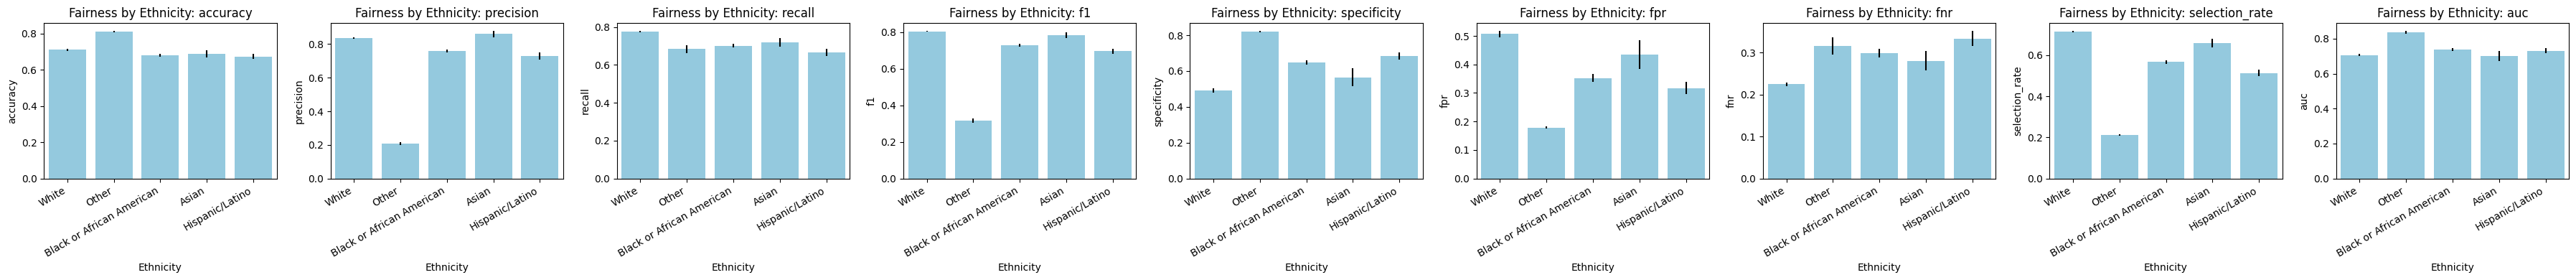

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

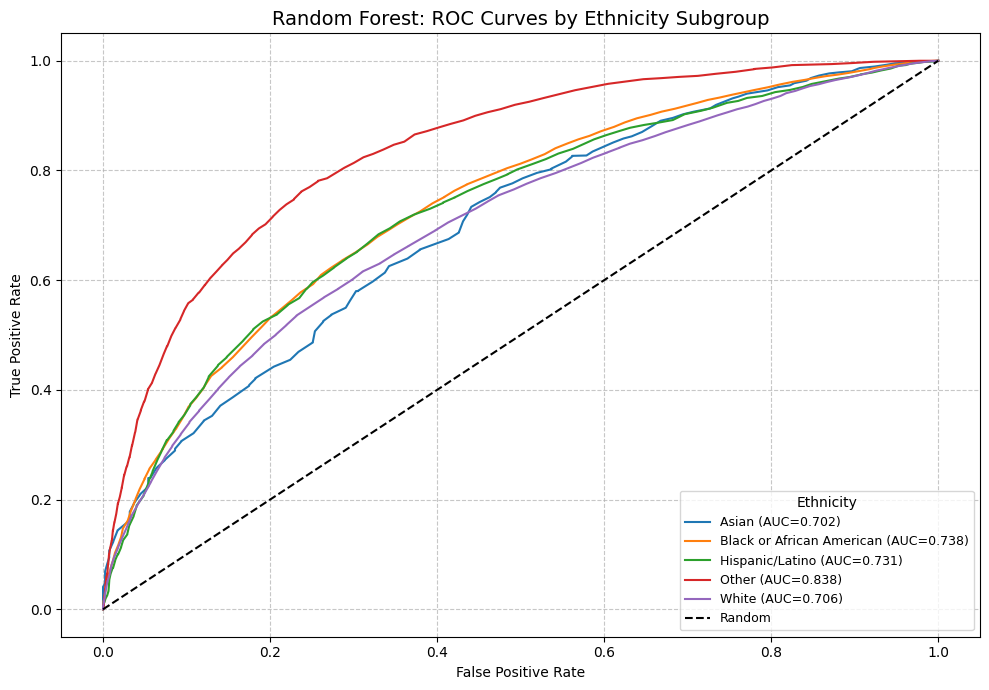

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('Random Forest: ROC Curves by Ethnicity Subgroup', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = probs[:, 1][valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== Random Forest Per-Age Group Metrics(Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Random Forest Per-Age Group Metrics(Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.81006, CI = (0.80164, 0.81774)
precision        Mean = 0.62057, CI = (0.59571, 0.64407)
recall           Mean = 0.45277, CI = (0.43290, 0.47307)
f1               Mean = 0.52348, CI = (0.50474, 0.54143)
specificity      Mean = 0.91708, CI = (0.91056, 0.92358)
fpr              Mean = 0.08292, CI = (0.07642, 0.08944)
fnr              Mean = 0.54723, CI = (0.52693, 0.56710)
selection_rate   Mean = 0.16816, CI = (0.16091, 0.17586)
auc              Mean = 0.81078, CI = (0.80133, 0.82074)

Age Group 25–34:
accuracy         Mean = 0.77845, CI = (0.77109, 0.78535)
precision        Mean = 0.64094, CI = (0.62270, 0.65976)
recall           Mean = 0.46140, CI = (0.44480, 0.47724)
f1               Mean = 0.53651, CI = (0.52188, 0.55094)
specificity      Mean = 0.90050, CI = (0.89443, 0.90655)
fpr              Mean = 0.09950, CI = (0.09345, 0.10557)
fnr              Mean = 0.53860, CI = (0.52276, 0

<ipython-input-29-458288792>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-458288792>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-458288792>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-458288792>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-458288792>:32: UserWarning: set_ticklabels() should only be used w

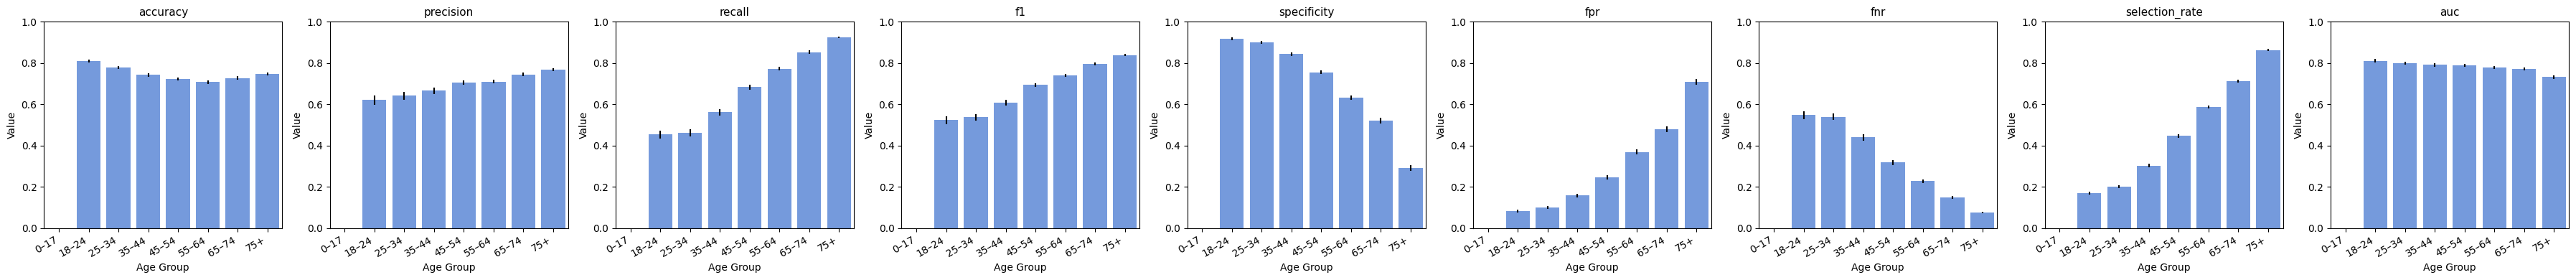

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


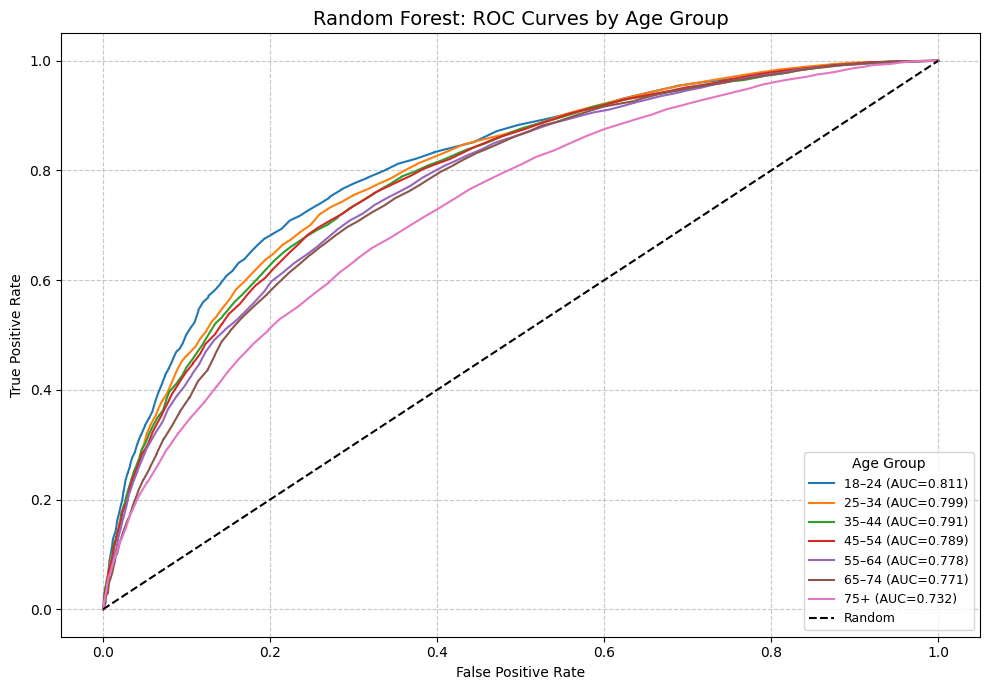

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('Random Forest: ROC Curves by Age Group', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


GradientBoosting:
Training time: 112.2507209777832 seconds
AUC: 0.8201988297540278
AUPRC: 0.7957168248989451
Sensitivity: 0.738986218173324
Specificity: 0.7435837362356499
Score thresold: 0.49401972301340785
2.5 97.5


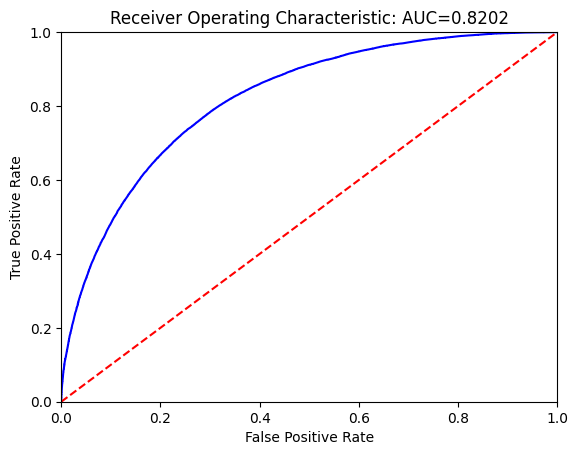

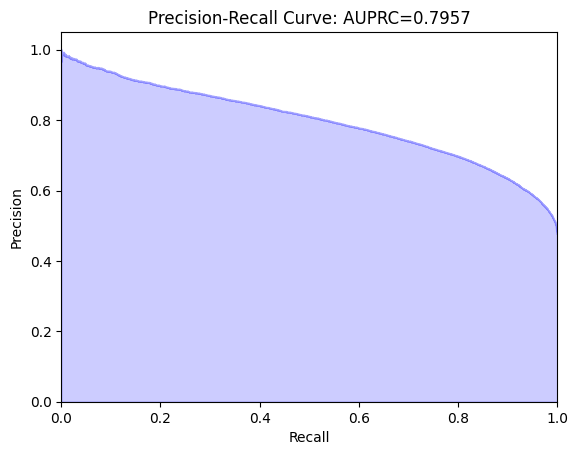

In [ ]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

threshold = result[4]
y_pred = (probs[:, 1] >= threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)
results.append(accuracy)

In [ ]:
result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity',
    'runtime', 'accuracy'
])
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF,0.498,0.82 (0.818-0.822),0.787 (0.784-0.79),0.751 (0.744-0.761),0.738 (0.726-0.742),125.842
1,GB,0.494,0.82 (0.818-0.822),0.796 (0.792-0.799),0.739 (0.735-0.757),0.744 (0.726-0.746),112.251


In [ ]:
probs = gb.predict_proba(X_test)
y_pred = (probs[:, 1] >= 0.494).astype(int)

In [ ]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[:, 1][valid_mask]  # important for AUC
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== Gradient Boosting Per-Gender Metrics (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== Gradient Boosting Per-Gender Metrics (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.74440, CI = (0.74075, 0.74816)
precision        Mean = 0.71621, CI = (0.71081, 0.72189)
recall           Mean = 0.70602, CI = (0.70000, 0.71188)
f1               Mean = 0.71107, CI = (0.70643, 0.71591)
specificity      Mean = 0.77524, CI = (0.77040, 0.78032)
fpr              Mean = 0.22476, CI = (0.21968, 0.22960)
fnr              Mean = 0.29398, CI = (0.28812, 0.30000)
selection_rate   Mean = 0.43915, CI = (0.43489, 0.44337)
auc              Mean = 0.82159, CI = (0.81814, 0.82530)

Male:
accuracy         Mean = 0.73773, CI = (0.73322, 0.74210)
precision        Mean = 0.73200, CI = (0.72598, 0.73774)
recall           Mean = 0.77261, CI = (0.76696, 0.77798)
f1               Mean = 0.75176, CI = (0.74724, 0.75626)
specificity      Mean = 0.70084, CI = (0.69414, 0.70678)
fpr              Mean = 0.29916, CI = (0.29322, 0.30586)
fnr              Mean = 0.22739, CI = (0.22202, 0.23304)
selection_

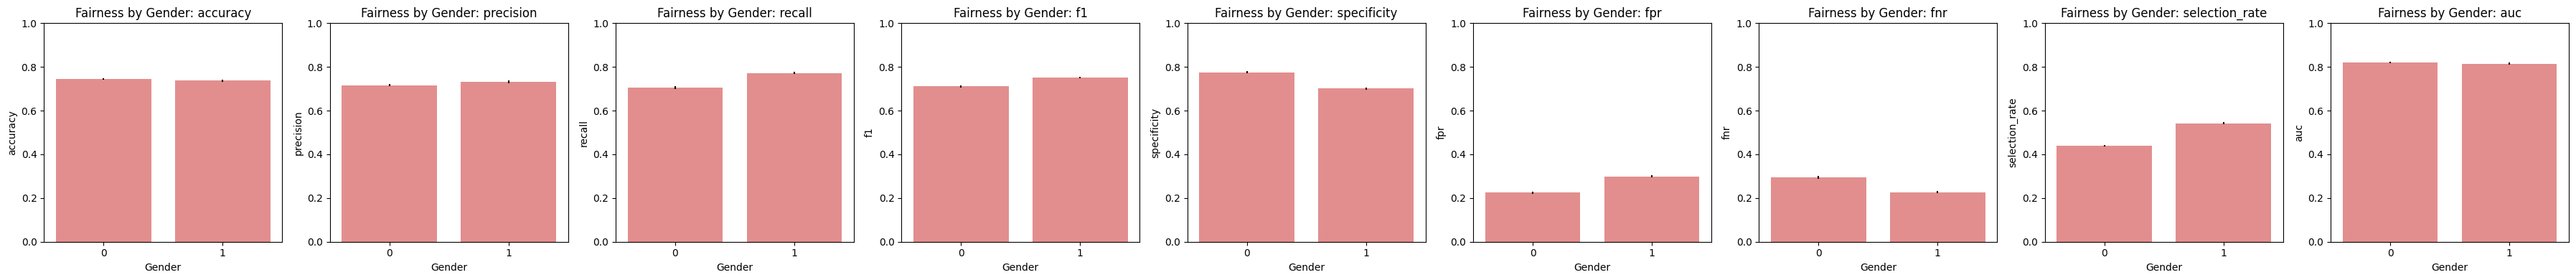

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<ipython-input-40-1529479638>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


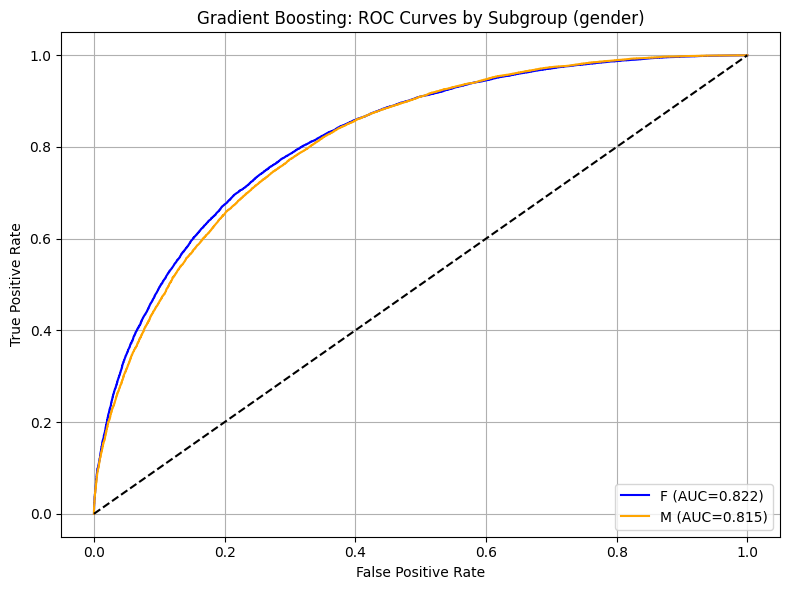

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('Gradient Boosting: ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = probs[:, 1][valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== Gradient Boosting Per-Ethnicity Metrics (Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Gradient Boosting Per-Ethnicity Metrics (Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.64984, CI = (0.62780, 0.67059)
precision        Mean = 0.85294, CI = (0.83160, 0.87260)
recall           Mean = 0.67190, CI = (0.64823, 0.69471)
f1               Mean = 0.75160, CI = (0.73331, 0.76929)
specificity      Mean = 0.56752, CI = (0.52000, 0.61905)
fpr              Mean = 0.43248, CI = (0.38095, 0.48000)
fnr              Mean = 0.32810, CI = (0.30529, 0.35177)
selection_rate   Mean = 0.62131, CI = (0.59895, 0.64293)
auc              Mean = 0.69239, CI = (0.66375, 0.72168)

Black or African American:
accuracy         Mean = 0.67564, CI = (0.66716, 0.68373)
precision        Mean = 0.75775, CI = (0.74811, 0.76748)
recall           Mean = 0.69243, CI = (0.68208, 0.70257)
f1               Mean = 0.72361, CI = (0.71557, 0.73164)
specificity      Mean = 0.64903, CI = (0.63595, 0.66190)
fpr              Mean = 0.35097, CI = (0.33810, 0.36405)
fnr              Mean = 0.30757, CI = (0.297

<ipython-input-42-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-42-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-42-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-42-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-42-1104984648>:28: UserWarning: set_ticklabels() should only be u

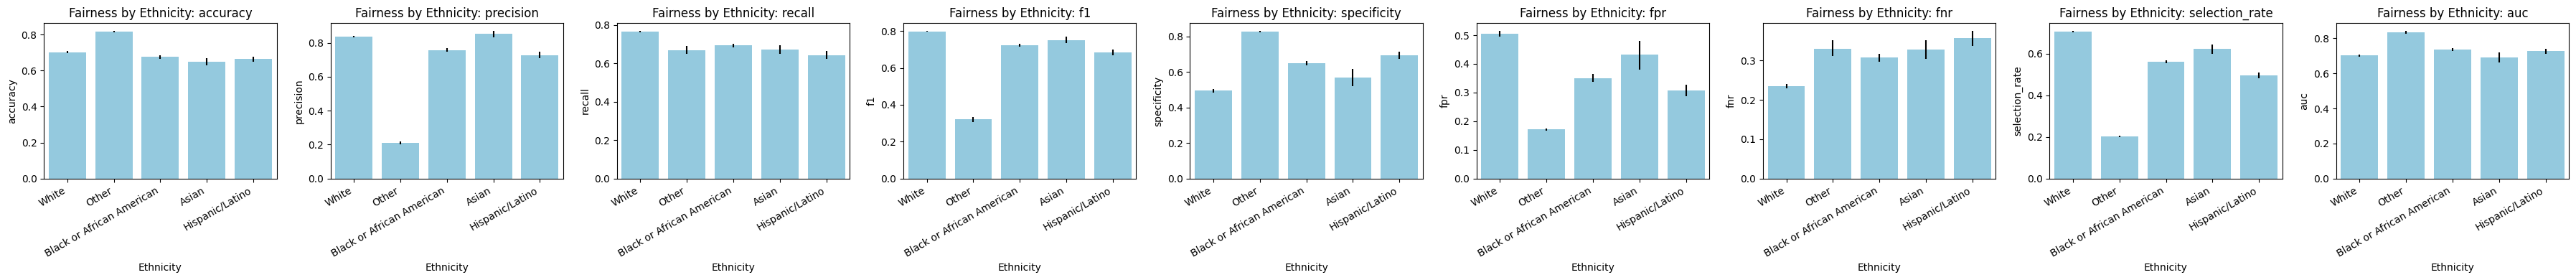

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

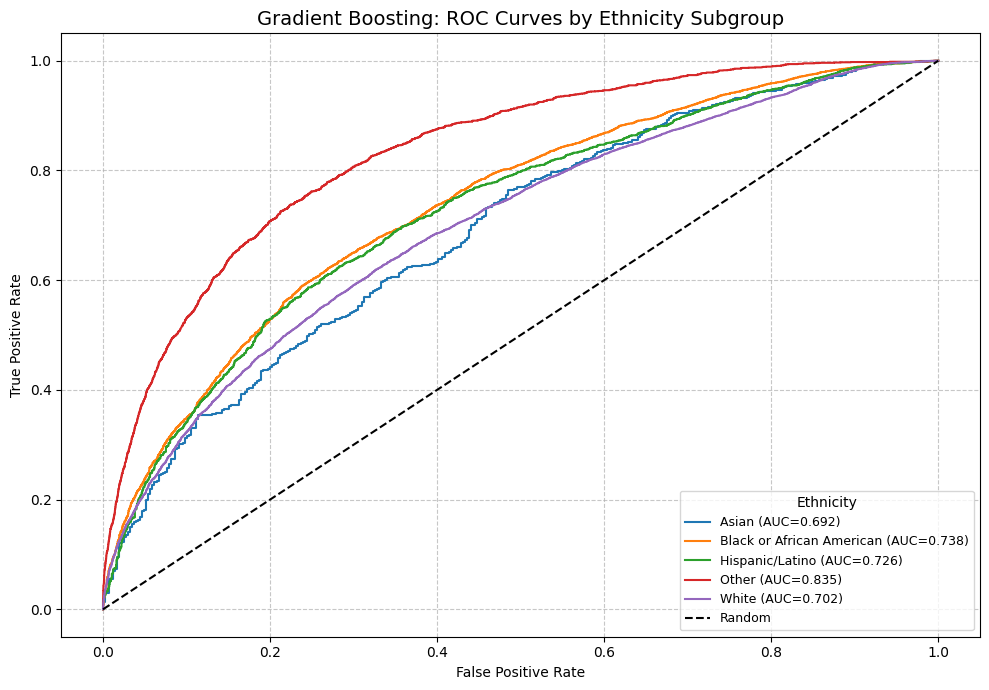

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('Gradient Boosting: ROC Curves by Ethnicity Subgroup', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = probs[:, 1][valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== Gradient Boosting Per-Age Group Metrics(Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== Gradient Boosting Per-Age Group Metrics(Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.80258, CI = (0.79435, 0.81045)
precision        Mean = 0.62783, CI = (0.60217, 0.65502)
recall           Mean = 0.35223, CI = (0.33272, 0.37298)
f1               Mean = 0.45121, CI = (0.43149, 0.47172)
specificity      Mean = 0.93747, CI = (0.93191, 0.94279)
fpr              Mean = 0.06253, CI = (0.05721, 0.06809)
fnr              Mean = 0.64777, CI = (0.62702, 0.66728)
selection_rate   Mean = 0.12930, CI = (0.12264, 0.13599)
auc              Mean = 0.80743, CI = (0.79751, 0.81726)

Age Group 25–34:
accuracy         Mean = 0.77555, CI = (0.76819, 0.78216)
precision        Mean = 0.64852, CI = (0.62977, 0.66765)
recall           Mean = 0.42023, CI = (0.40564, 0.43530)
f1               Mean = 0.50996, CI = (0.49547, 0.52484)
specificity      Mean = 0.91233, CI = (0.90652, 0.91787)
fpr              Mean = 0.08767, CI = (0.08213, 0.09348)
fnr              Mean = 0.57977, CI = (0.5647

<ipython-input-45-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-45-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-45-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-45-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-45-4263358289>:32: UserWarning: set_ticklabels() should only be u

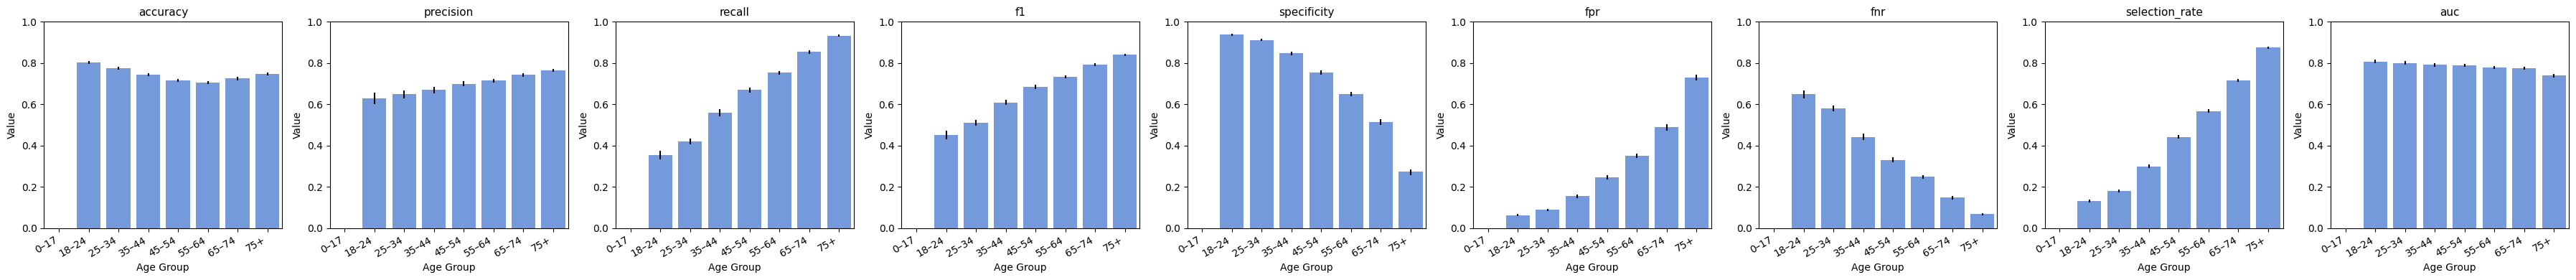

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

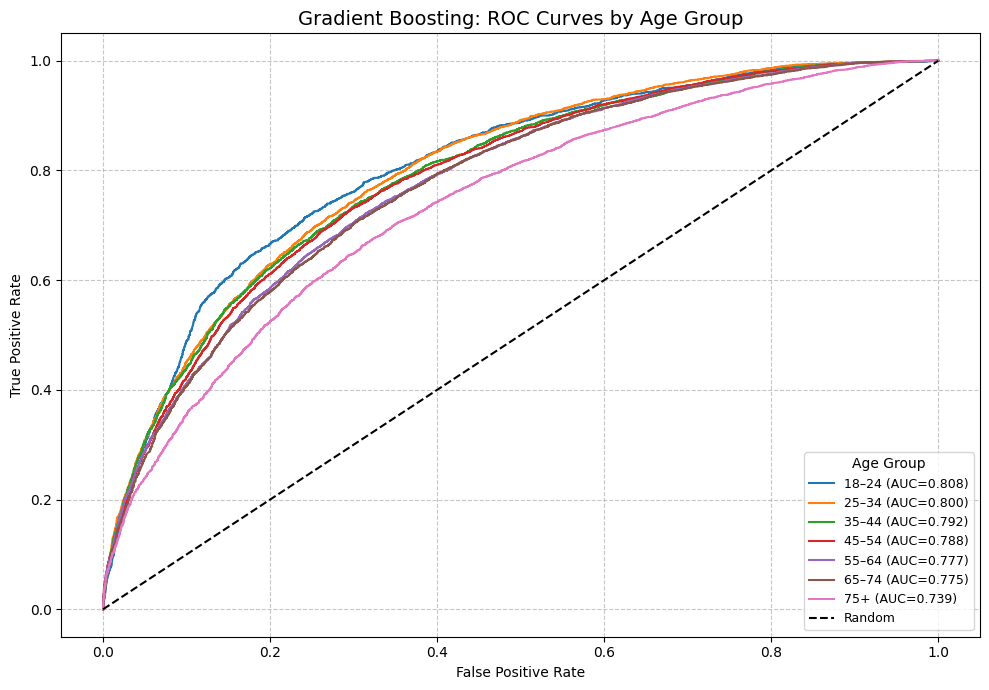

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('Gradient Boosting: ROC Curves by Age Group', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class MLP(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [18]:
import numpy as np
import time
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import load_model

# === Step 1: 定义需要标准化的连续变量列 ===
vars_to_standardize = [
    "age", "n_ed_30d", "n_ed_90d", "n_ed_365d",
    "n_hosp_30d", "n_hosp_90d", "n_hosp_365d",
    "n_icu_30d", "n_icu_90d", "n_icu_365d",
    "triage_temperature", "triage_heartrate",
    "triage_resprate", "triage_o2sat",
    "triage_sbp", "triage_dbp", "triage_pain"
]

# === Step 2: 标准化训练集和测试集 ===
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[vars_to_standardize] = scaler.fit_transform(X_train[vars_to_standardize])
X_test_scaled[vars_to_standardize] = scaler.transform(X_test[vars_to_standardize])

# 保存 scaler，用于未来部署复现
with open('mlp_input_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# === Step 3: 构建并训练 MLP 模型 ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

mlp.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy'),
        metrics.AUC(name='auc'),
        metrics.AUC(name='auprc', curve='PR'),
        metrics.TruePositives(name='tp'),
        metrics.TrueNegatives(name='tn'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

print("Training MLP model...")
start = time.time()
mlp.fit(X_train_scaled.astype(np.float32), y_train, batch_size=200, epochs=20, verbose=1)
runtime = time.time() - start
print('Training time:', round(runtime, 2), 'seconds')

# === Step 4: 保存模型 ===
mlp.save('hospitalization_triage_mlp.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training MLP model...
Epoch 1/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7013 - auc: 0.7696 - auprc: 0.7377 - loss: 0.5723 - precision: 0.6962 - recall: 0.6602 - tn: 69474.2109 - tp: 58957.5039
Epoch 2/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7343 - auc: 0.8087 - auprc: 0.7809 - loss: 0.5328 - precision: 0.7117 - recall: 0.7463 - tn: 67951.3125 - tp: 64157.4766
Epoch 3/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7383 - auc: 0.8145 - auprc: 0.7879 - loss: 0.5260 - precision: 0.7176 - recall: 0.7452 - tn: 68700.5312 - tp: 63922.7422
Epoch 4/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7395 - auc: 0.8158 - auprc: 0.7904 - loss: 0.5239 - precision: 0.7195 - recall: 0.7467 - tn: 68736.3047 - tp: 64247.3711
Epoch 5/20
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7403 - auc: 0.8169 - auprc: 0.7897 - loss: 0.5225 - precision: 0.7203 - recall: 0.7443 - tn: 69173.4922 - tp: 63974.4375
Epoch 6/20
1796/1796 ━━━━━━━━━━━

MLP Evaluation:
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
AUC: 0.8254698274923002
AUPRC: 0.8013967239713955
Sensitivity: 0.7548937164213969
Specificity: 0.7381951396136397
Score thresold: 0.4990108
2.5 97.5


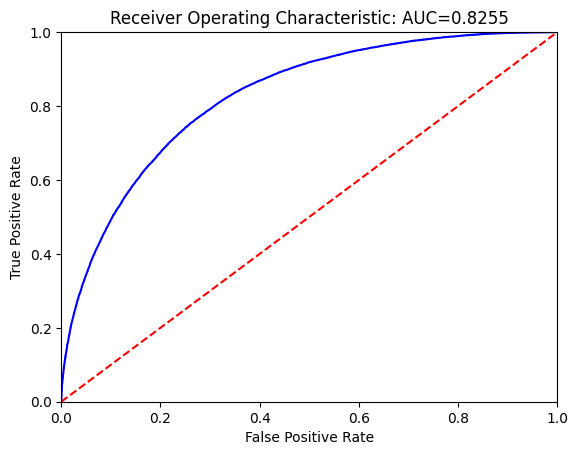

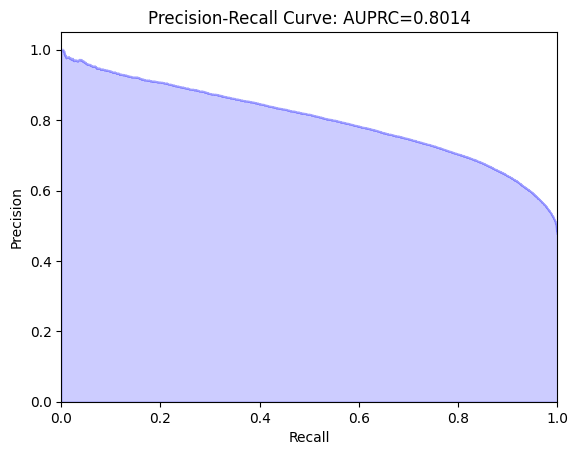

Accuracy: 0.7461481044106015


In [19]:
print("MLP Evaluation:")
mlp = load_model('hospitalization_triage_mlp.keras')

# Step 5: 模型预测 + 评估
probs = mlp.predict(X_test_scaled.astype(np.float32)).flatten()

# Plot and compute ROC-based metrics
result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)

# Compute accuracy using optimal threshold
from sklearn.metrics import accuracy_score
threshold = result[4]
y_pred = (probs > threshold).astype(int)
acc = accuracy_score(y_test, y_pred)

# Save results
results = ["MLP"]
results.extend(result)
results.append(runtime)
results.append(acc)
result_list.append(results)

print("Accuracy:", acc)


In [ ]:
result_list = [results]

result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap',
    'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df['Accuracy'] = result_df['accuracy']

formatted_result_df


,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime,Accuracy
0,MLP,0.5,0.826 (0.824-0.828),0.801 (0.798-0.804),0.759 (0.743-0.776),0.734 (0.72-0.752),144.516,0.746


In [20]:
probs = mlp.predict(X_test_scaled.astype(np.float32)).flatten()
y_pred = (probs >= 0.5).astype(int)


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 3s 1000us/step


In [21]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = probs[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== MLP Per-Gender Metrics (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== MLP Per-Gender Metrics (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.74869, CI = (0.74515, 0.75229)
precision        Mean = 0.71727, CI = (0.71180, 0.72273)
recall           Mean = 0.71951, CI = (0.71323, 0.72531)
f1               Mean = 0.71838, CI = (0.71380, 0.72292)
specificity      Mean = 0.77214, CI = (0.76753, 0.77672)
fpr              Mean = 0.22786, CI = (0.22328, 0.23247)
fnr              Mean = 0.28049, CI = (0.27469, 0.28677)
selection_rate   Mean = 0.44688, CI = (0.44246, 0.45131)
auc              Mean = 0.82674, CI = (0.82298, 0.83019)

Male:
accuracy         Mean = 0.74309, CI = (0.73894, 0.74732)
precision        Mean = 0.73220, CI = (0.72634, 0.73793)
recall           Mean = 0.78859, CI = (0.78329, 0.79386)
f1               Mean = 0.75935, CI = (0.75487, 0.76397)
specificity      Mean = 0.69496, CI = (0.68823, 0.70128)
fpr              Mean = 0.30504, CI = (0.29872, 0.31177)
fnr              Mean = 0.21141, CI = (0.20614, 0.21671)
selection_rate   Mean = 

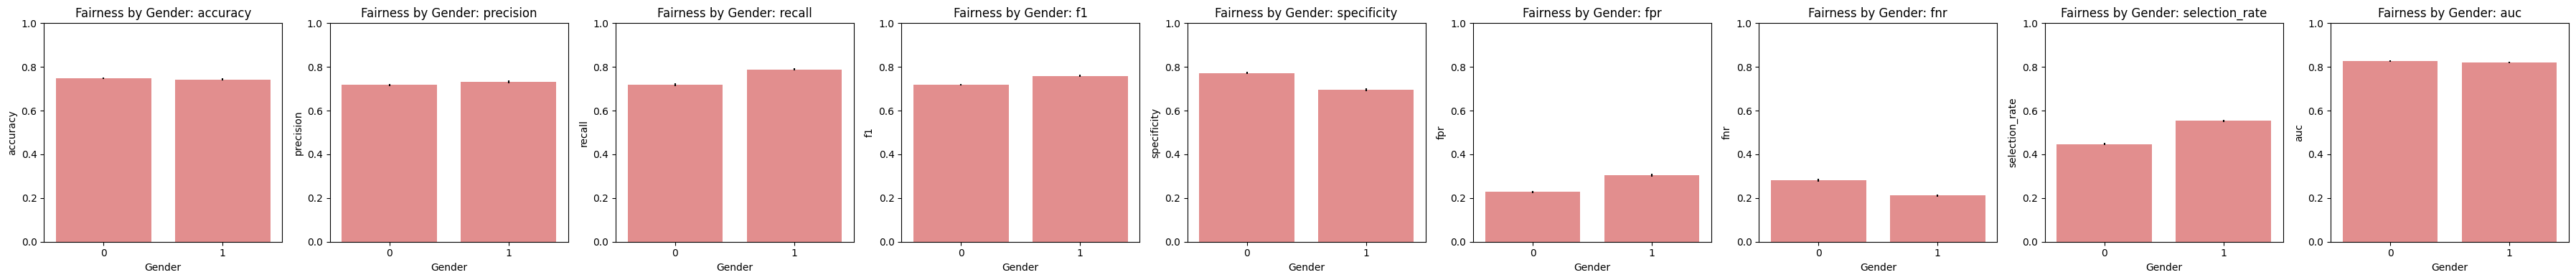

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<ipython-input-23-2021355835>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


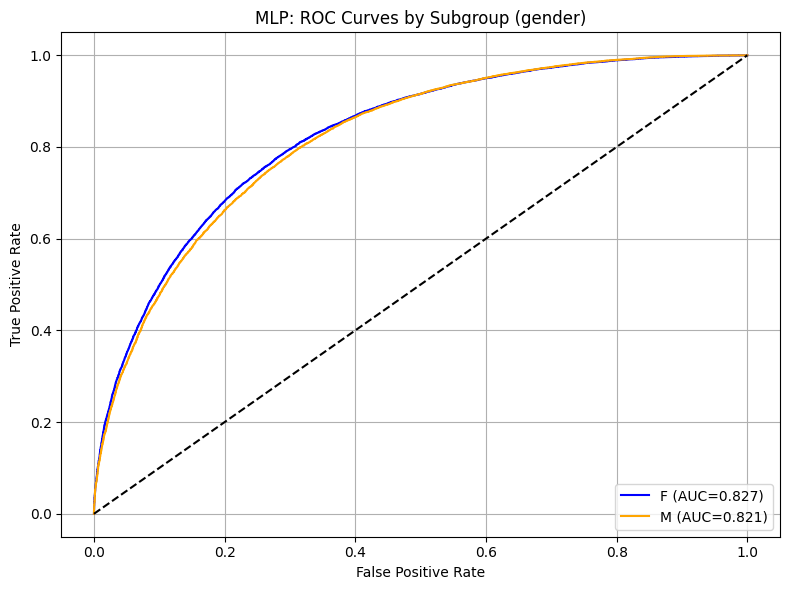

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('MLP: ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = probs[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== MLP Per-Ethnicity Metrics (Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== MLP Per-Ethnicity Metrics (Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.68979, CI = (0.66976, 0.70975)
precision        Mean = 0.86185, CI = (0.84332, 0.88078)
recall           Mean = 0.72251, CI = (0.70013, 0.74498)
f1               Mean = 0.78599, CI = (0.76883, 0.80166)
specificity      Mean = 0.56765, CI = (0.51947, 0.61751)
fpr              Mean = 0.43235, CI = (0.38249, 0.48053)
fnr              Mean = 0.27749, CI = (0.25502, 0.29987)
selection_rate   Mean = 0.66120, CI = (0.63963, 0.68210)
auc              Mean = 0.69861, CI = (0.66808, 0.72835)

Black or African American:
accuracy         Mean = 0.68995, CI = (0.68183, 0.69837)
precision        Mean = 0.77203, CI = (0.76289, 0.78253)
recall           Mean = 0.70156, CI = (0.69168, 0.71219)
f1               Mean = 0.73510, CI = (0.72734, 0.74265)
specificity      Mean = 0.67154, CI = (0.65872, 0.68497)
fpr              Mean = 0.32846, CI = (0.31503, 0.34128)
fnr              Mean = 0.29844, CI = (0.28781, 0.30832)
s

<ipython-input-25-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-25-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-25-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-25-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-25-1104984648>:28: UserWarning: set_ticklabels() should only be u

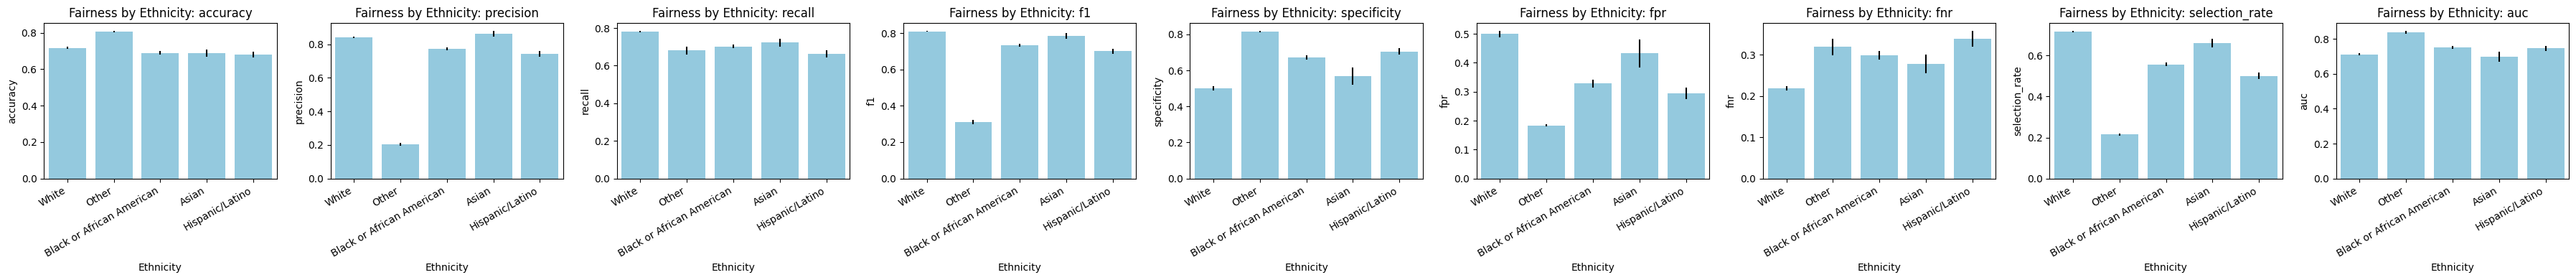

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

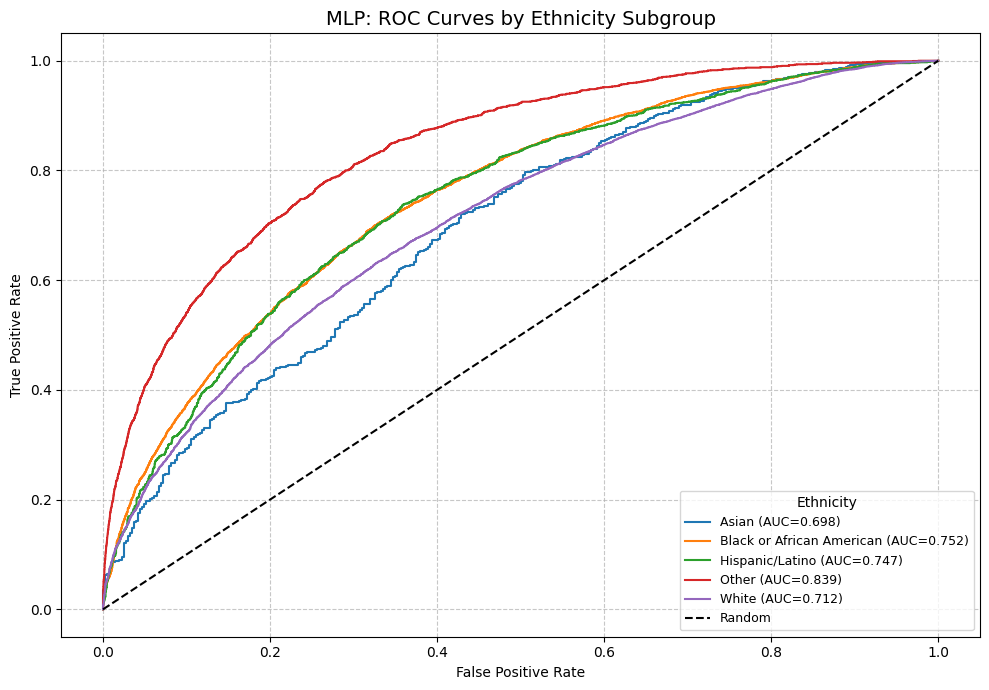

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('MLP: ROC Curves by Ethnicity Subgroup', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [27]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = probs[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== MLP Per-Age Group Metrics (Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== MLP Per-Age Group Metrics (Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.80608, CI = (0.79779, 0.81384)
precision        Mean = 0.61513, CI = (0.59167, 0.63966)
recall           Mean = 0.42382, CI = (0.40429, 0.44609)
f1               Mean = 0.50180, CI = (0.48302, 0.52244)
specificity      Mean = 0.92058, CI = (0.91428, 0.92690)
fpr              Mean = 0.07942, CI = (0.07310, 0.08572)
fnr              Mean = 0.57618, CI = (0.55391, 0.59571)
selection_rate   Mean = 0.15880, CI = (0.15198, 0.16630)
auc              Mean = 0.81197, CI = (0.80227, 0.82148)

Age Group 25–34:
accuracy         Mean = 0.77833, CI = (0.77130, 0.78531)
precision        Mean = 0.63941, CI = (0.62078, 0.65668)
recall           Mean = 0.46432, CI = (0.44670, 0.48059)
f1               Mean = 0.53794, CI = (0.52224, 0.55264)
specificity      Mean = 0.89921, CI = (0.89314, 0.90494)
fpr              Mean = 0.10079, CI = (0.09506, 0.10686)
fnr              Mean = 0.53568, CI = (0.51941, 0.55330)
s

<ipython-input-29-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-29-4263358289>:32: UserWarning: set_ticklabels() should only be u

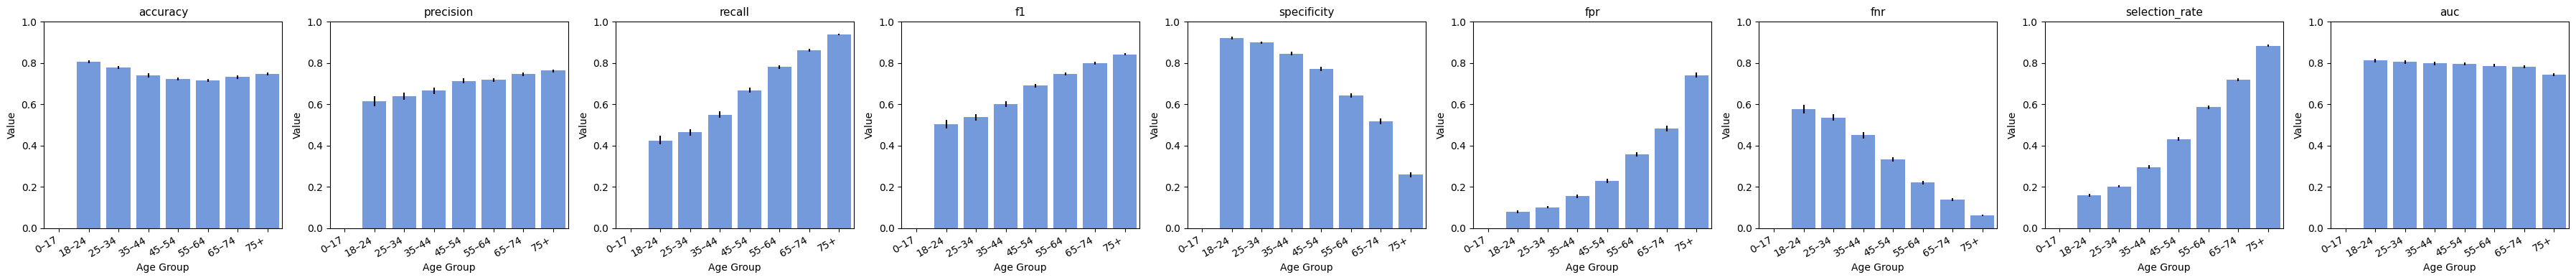

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

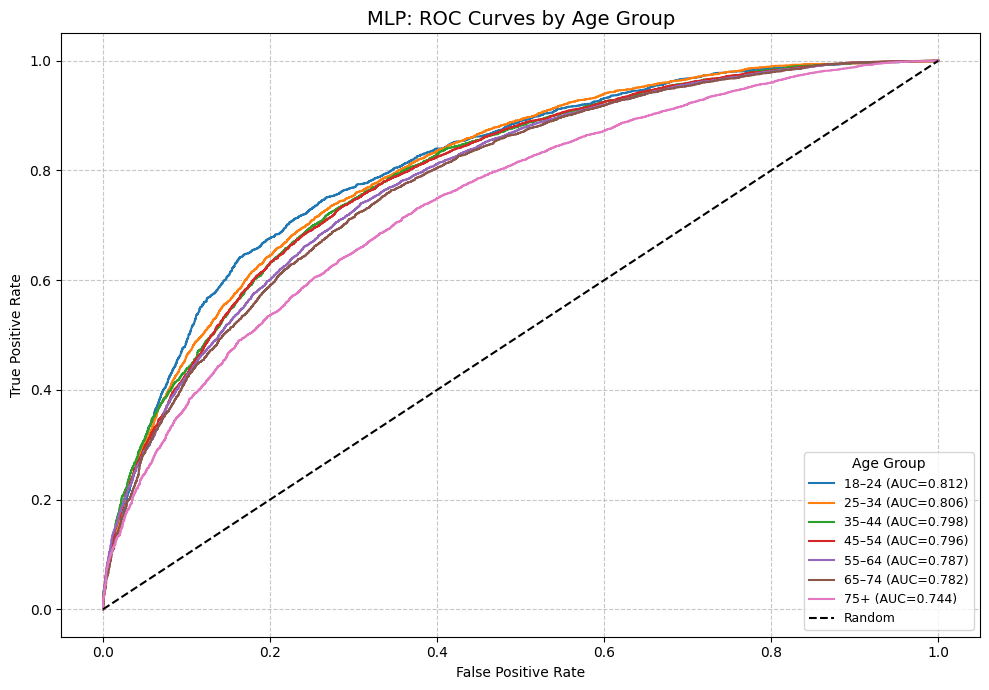

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('MLP: ROC Curves by Age Group', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Evaluating: esi
AUC: 0.7122123147557193
AUPRC: 0.6340350282626551
Sensitivity: 0.5952581172623219
Specificity: 0.774914272326468
Score thresold: -2.6248987751080204
2.5 97.5


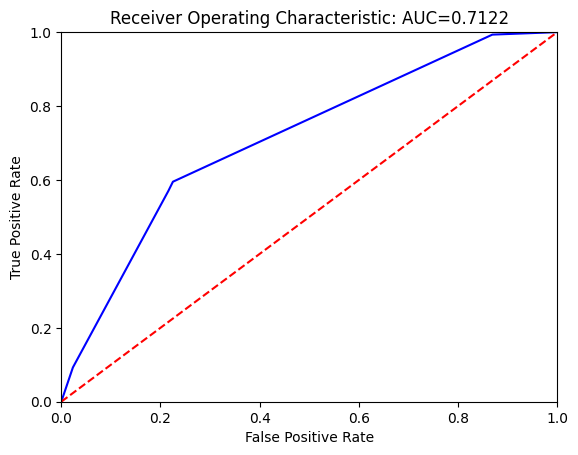

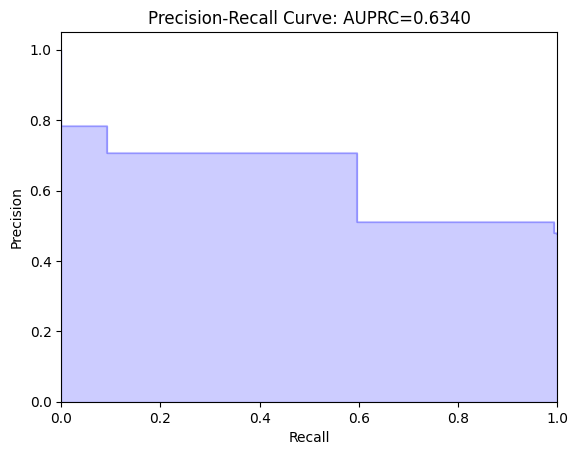

In [50]:
from sklearn.metrics import accuracy_score
import numpy as np

result_list = []

def get_score_performance(s, random_seed=0):
    print(f"Evaluating: {s}")
    score = np.array(df_test[s])

    result = PlotROCCurve(score, y_test, ci=confidence_interval, random_seed=random_seed)

    threshold = result[4]
    y_pred = (score >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)

    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    results.append(acc)

    result_list.append(results)

df_test["esi"] = -df_test["triage_acuity"]

get_score_performance("esi", random_seed=random_seed)

In [51]:
result_df = pd.DataFrame(result_list, columns=[
    'Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold',
    'lower_auroc', 'upper_auroc', 'std_auroc',
    'lower_ap', 'upper_ap', 'std_ap',
    'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity',
    'lower_specificity', 'upper_specificity', 'std_specificity',
    'runtime', 'accuracy'
])

result_df = result_df.round(3)

formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df['Accuracy'] = result_df['accuracy']
formatted_result_df['Runtime'] = result_df['runtime']
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Accuracy,Runtime
0,esi,-2.625,0.712 (0.71-0.715),0.634 (0.632-0.639),0.595 (0.593-0.601),0.775 (0.772-0.778),0.689,0


In [52]:
esi_score = df_test["esi"]
y_pred = (esi_score >= -2.625).astype(int)

In [53]:
# Clean gender variable
gender_raw = df_test['gender']
valid_mask = (
    gender_raw.notna() &
    (gender_raw != '') &
    (gender_raw.str.lower() != 'unknown')
)

# Apply mask to target and predictions
y_test_gender = y_test[valid_mask]
y_pred_gender = y_pred[valid_mask]
y_score_gender = esi_score[valid_mask]
gender_clean = gender_raw[valid_mask]
gender_grouped = gender_clean.str.upper().map({'F': 0, 'M': 1})

# Create dataframe for bootstrap function
fair_df = pd.DataFrame({
    'y_true': y_test_gender,
    'y_pred': y_pred_gender,
    'y_score': y_score_gender,
    'gender': gender_grouped
})

# Run bootstrapped fairness metric CI
ci_df_gender = bootstrap_fairness_metric_ci(
    df=fair_df,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='gender',
    B=1000,
    random_seed=42
)

# Print formatted output
print("\n=== ESI Per-Gender Metrics (Mean + 95% CI) ===")
for group in ['Female', 'Male']:
    group_id = 0 if group == 'Female' else 1
    group_metrics = ci_df_gender[ci_df_gender['Group'] == group_id]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")


=== ESI Per-Gender Metrics (Mean + 95% CI) ===

Female:
accuracy         Mean = 0.68831, CI = (0.68428, 0.69230)
precision        Mean = 0.67965, CI = (0.67343, 0.68606)
recall           Mean = 0.56811, CI = (0.56114, 0.57476)
f1               Mean = 0.61889, CI = (0.61317, 0.62461)
specificity      Mean = 0.78487, CI = (0.78041, 0.78955)
fpr              Mean = 0.21513, CI = (0.21045, 0.21959)
fnr              Mean = 0.43189, CI = (0.42524, 0.43886)
selection_rate   Mean = 0.37238, CI = (0.36773, 0.37695)
auc              Mean = 0.70306, CI = (0.69885, 0.70704)

Male:
accuracy         Mean = 0.69038, CI = (0.68589, 0.69511)
precision        Mean = 0.73436, CI = (0.72773, 0.74111)
recall           Mean = 0.62297, CI = (0.61687, 0.62915)
f1               Mean = 0.67409, CI = (0.66880, 0.67942)
specificity      Mean = 0.76167, CI = (0.75576, 0.76752)
fpr              Mean = 0.23833, CI = (0.23248, 0.24424)
fnr              Mean = 0.37703, CI = (0.37085, 0.38313)
selection_rate   Mean = 

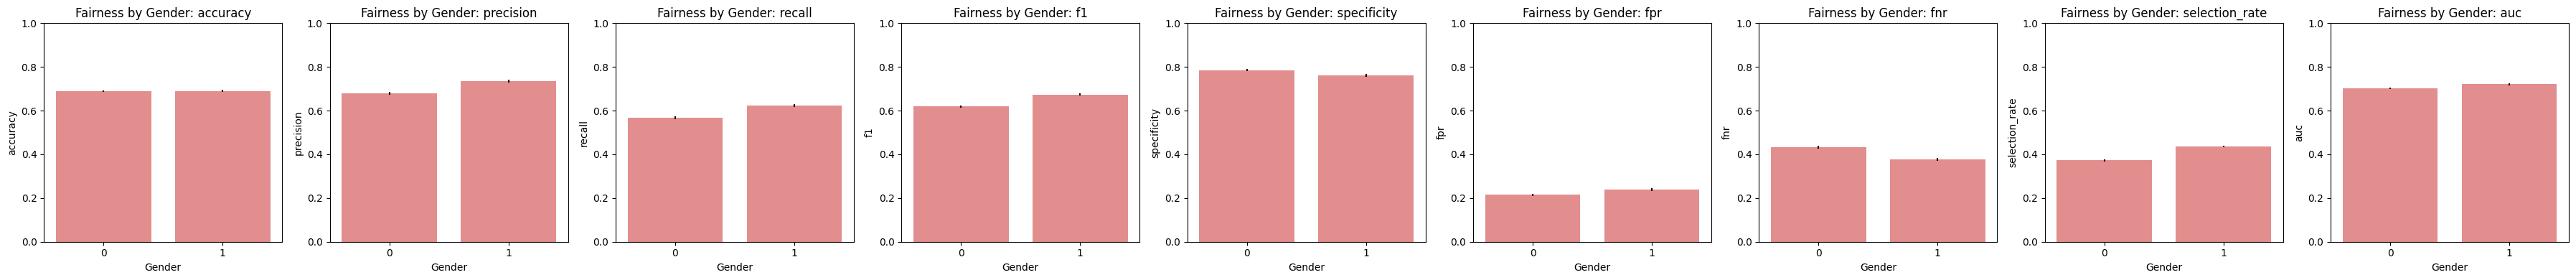

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_gender['Error Lower'] = ci_df_gender['Mean'] - ci_df_gender['CI_lower']
ci_df_gender['Error Upper'] = ci_df_gender['CI_upper'] - ci_df_gender['Mean']

metrics = ci_df_gender['Metric'].unique()
n_metrics = len(metrics)

# Plot setup
fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_gender[ci_df_gender['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='lightcoral'
    )
    ax.set_title(f'Fairness by Gender: {metric}')
    ax.set_xlabel('Gender')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

<ipython-input-55-3404451348>:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--')


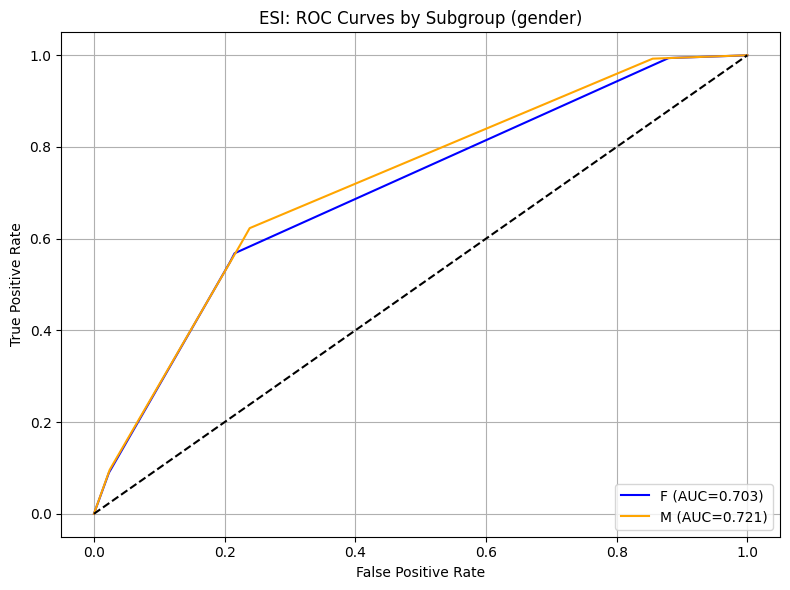

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split by gender
female_df = fair_df[fair_df['gender'] == 0]  # Female
male_df = fair_df[fair_df['gender'] == 1]    # Male

# Calculate ROC curve points and AUC
fpr_f, tpr_f, _ = roc_curve(female_df['y_true'], female_df['y_score'])
auc_f = roc_auc_score(female_df['y_true'], female_df['y_score'])

fpr_m, tpr_m, _ = roc_curve(male_df['y_true'], male_df['y_score'])
auc_m = roc_auc_score(male_df['y_true'], male_df['y_score'])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label=f'F (AUC={auc_f:.3f})', color='blue')
plt.plot(fpr_m, tpr_m, label=f'M (AUC={auc_m:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', linestyle='--')

plt.title('ESI: ROC Curves by Subgroup (gender)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Clean and validate ethnicity
ethnicity_raw = df_test['ethnicity'].astype(str)
valid_mask = (
    ethnicity_raw.notna() &
    (ethnicity_raw.str.strip() != '') &
    (~ethnicity_raw.str.lower().isin(['unknown', 'unable to obtain']))
)

# Apply mask to target and predictions
y_test_ethnicity = y_test[valid_mask]
y_pred_ethnicity = y_pred[valid_mask]
y_score_ethnicity = esi_score[valid_mask]
ethnicity_clean = ethnicity_raw[valid_mask].str.strip().str.lower()

# Step 3: Map ethnicity into grouped labels
ethnicity_grouped = ethnicity_clean.map({
    'white': 'White',
    'black/african american': 'Black or African American',
    'asian': 'Asian',
    'hispanic/latino': 'Hispanic/Latino',
    'other': 'Other'
}).fillna('Other')

fair_df_ethnicity = pd.DataFrame({
    'y_true': y_test_ethnicity,
    'y_pred': y_pred_ethnicity,
    'y_score': y_score_ethnicity,
    'ethnicity': ethnicity_grouped
})

# Run bootstrapped fairness metric CI
ci_df_ethnicity = bootstrap_fairness_metric_ci(
    df=fair_df_ethnicity,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='ethnicity',
    B=1000,
    random_seed=42
)

print("\n=== ESI Per-Ethnicity Metrics (Mean + 95% CI) ===")
for group in sorted(ci_df_ethnicity['Group'].unique()):
    group_metrics = ci_df_ethnicity[ci_df_ethnicity['Group'] == group]
    print(f"\n{group}:")
    for _, row in group_metrics.iterrows():
        metric = row['Metric']
        mean = row['Mean']
        ci_low = row['CI_lower']
        ci_high = row['CI_upper']
        print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== ESI Per-Ethnicity Metrics (Mean + 95% CI) ===

Asian:
accuracy         Mean = 0.63304, CI = (0.61217, 0.65449)
precision        Mean = 0.90919, CI = (0.89117, 0.92753)
recall           Mean = 0.59407, CI = (0.57030, 0.61973)
f1               Mean = 0.71852, CI = (0.69786, 0.73873)
specificity      Mean = 0.77852, CI = (0.73912, 0.81731)
fpr              Mean = 0.22148, CI = (0.18269, 0.26088)
fnr              Mean = 0.40593, CI = (0.38027, 0.42970)
selection_rate   Mean = 0.51536, CI = (0.49281, 0.53739)
auc              Mean = 0.70579, CI = (0.68134, 0.73046)

Black or African American:
accuracy         Mean = 0.63869, CI = (0.63029, 0.64694)
precision        Mean = 0.79962, CI = (0.78930, 0.81087)
recall           Mean = 0.54819, CI = (0.53710, 0.55867)
f1               Mean = 0.65043, CI = (0.64060, 0.65960)
specificity      Mean = 0.78219, CI = (0.77085, 0.79370)
fpr              Mean = 0.21781, CI = (0.20630, 0.22915)
fnr              Mean = 0.45181, CI = (0.44133, 0.46290)
s

<ipython-input-57-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-57-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-57-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-57-1104984648>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-57-1104984648>:28: UserWarning: set_ticklabels() should only be u

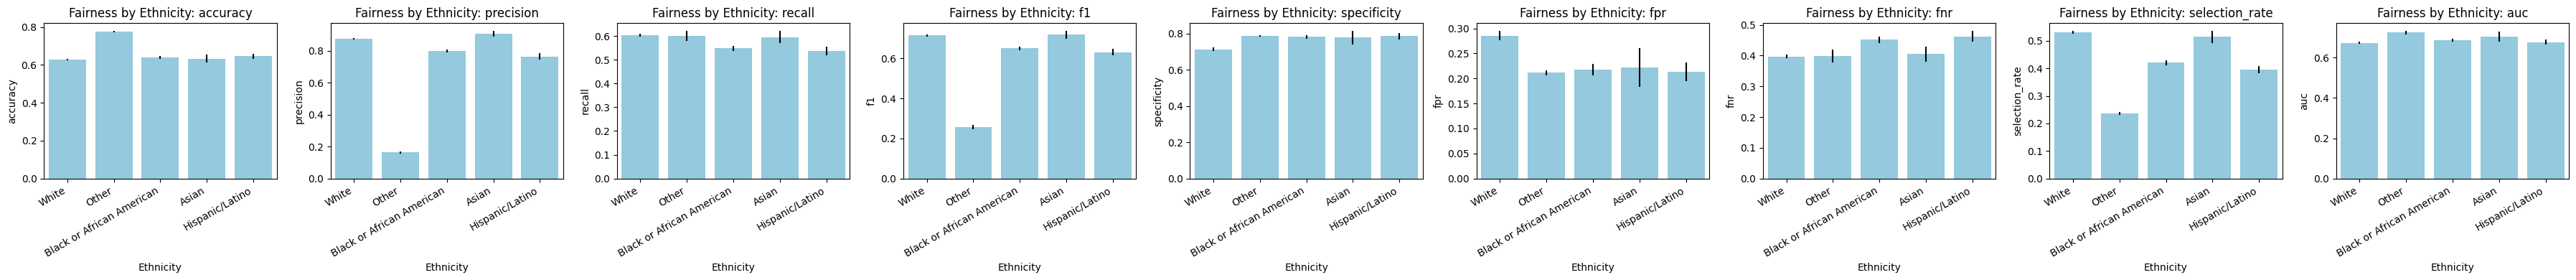

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

ci_df_ethnicity['Error Lower'] = ci_df_ethnicity['Mean'] - ci_df_ethnicity['CI_lower']
ci_df_ethnicity['Error Upper'] = ci_df_ethnicity['CI_upper'] - ci_df_ethnicity['Mean']

metrics = ci_df_ethnicity['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_ethnicity[ci_df_ethnicity['Metric'] == metric]

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='skyblue'
    )
    ax.set_title(f'Fairness by Ethnicity: {metric}')
    ax.set_xlabel('Ethnicity')
    ax.set_ylabel(metric)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()

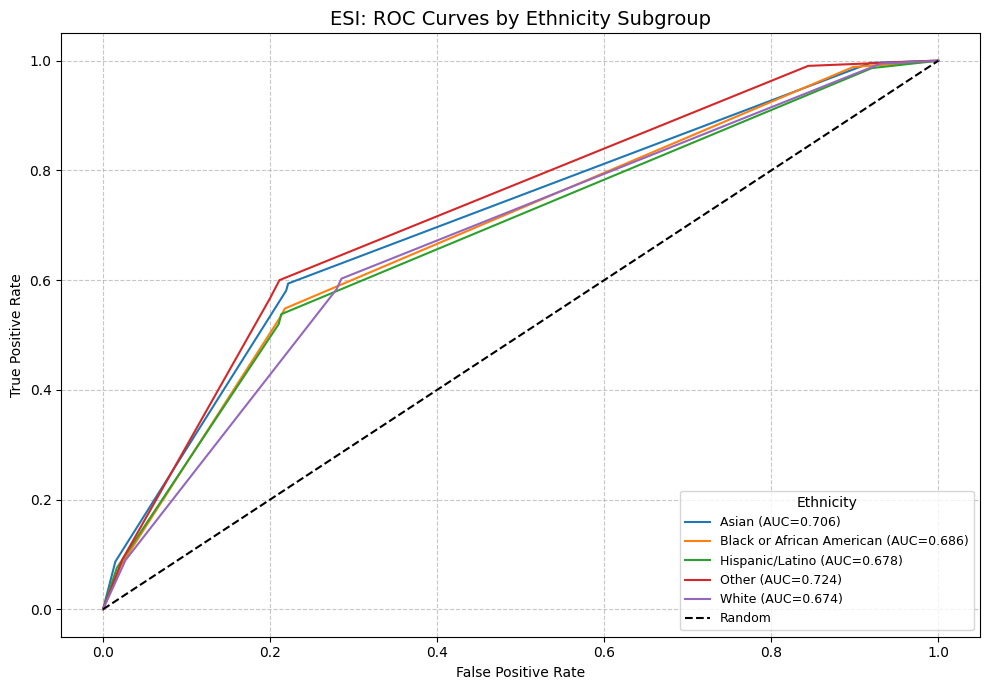

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

ethnicity_groups = fair_df_ethnicity['ethnicity'].unique()

# Plot setup
plt.figure(figsize=(10, 7))

for group in sorted(ethnicity_groups):
    group_df = fair_df_ethnicity[fair_df_ethnicity['ethnicity'] == group]

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title('ESI: ROC Curves by Ethnicity Subgroup', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [59]:
# Define age bins and labels
age_bins = [0, 17, 24, 34, 44, 54, 64, 74, 150]
age_labels = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']

age_grouped = pd.cut(X_test['age'], bins=age_bins, labels=age_labels, right=True)
valid_mask = age_grouped.notna()

y_test_age = y_test[valid_mask]
y_pred_age = y_pred[valid_mask]
y_score_age = esi_score[valid_mask]
age_grouped_clean = age_grouped[valid_mask]

fair_df_age = pd.DataFrame({
    'y_true': y_test_age,
    'y_pred': y_pred_age,
    'y_score': y_score_age,
    'age_group': age_grouped_clean
})

# Run bootstrapped fairness metric CI
ci_df_age = bootstrap_fairness_metric_ci(
    df=fair_df_age,
    y_true_col='y_true',
    y_pred_col='y_pred',
    y_score_col='y_score',
    group_col='age_group',
    B=1000,
    random_seed=42
)

print("\n=== ESI Per-Age Group Metrics (Mean + 95% CI) ===")
for group in age_labels:
    if group in ci_df_age['Group'].values:
        group_metrics = ci_df_age[ci_df_age['Group'] == group]
        print(f"\nAge Group {group}:")
        for _, row in group_metrics.iterrows():
            metric = row['Metric']
            mean = row['Mean']
            ci_low = row['CI_lower']
            ci_high = row['CI_upper']
            print(f"{metric:<16} Mean = {mean:.5f}, CI = ({ci_low:.5f}, {ci_high:.5f})")



=== ESI Per-Age Group Metrics (Mean + 95% CI) ===

Age Group 18–24:
accuracy         Mean = 0.78179, CI = (0.77334, 0.79038)
precision        Mean = 0.52303, CI = (0.50431, 0.54222)
recall           Mean = 0.60449, CI = (0.58348, 0.62635)
f1               Mean = 0.56076, CI = (0.54352, 0.57753)
specificity      Mean = 0.83489, CI = (0.82643, 0.84263)
fpr              Mean = 0.16511, CI = (0.15737, 0.17357)
fnr              Mean = 0.39551, CI = (0.37365, 0.41652)
selection_rate   Mean = 0.26638, CI = (0.25799, 0.27514)
auc              Mean = 0.75022, CI = (0.73961, 0.76030)

Age Group 25–34:
accuracy         Mean = 0.73372, CI = (0.72612, 0.74105)
precision        Mean = 0.52030, CI = (0.50503, 0.53512)
recall           Mean = 0.53803, CI = (0.52216, 0.55395)
f1               Mean = 0.52898, CI = (0.51608, 0.54210)
specificity      Mean = 0.80905, CI = (0.80127, 0.81666)
fpr              Mean = 0.19095, CI = (0.18334, 0.19873)
fnr              Mean = 0.46197, CI = (0.44605, 0.47784)
s

<ipython-input-60-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-60-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-60-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-60-4263358289>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
<ipython-input-60-4263358289>:32: UserWarning: set_ticklabels() should only be u

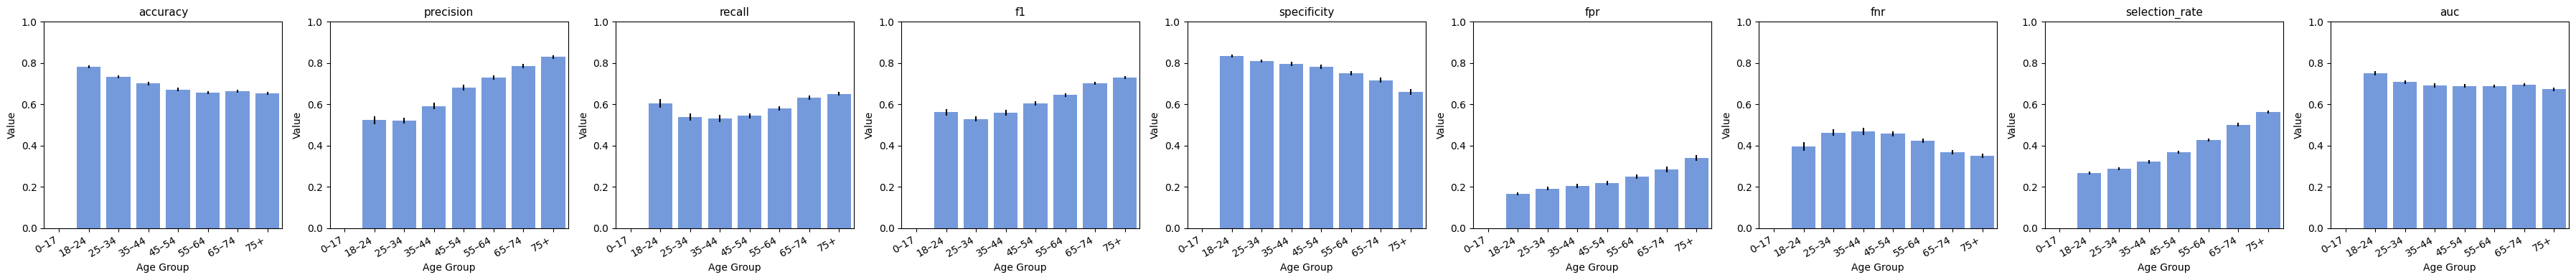

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ci_df_age['Error Lower'] = ci_df_age['Mean'] - ci_df_age['CI_lower']
ci_df_age['Error Upper'] = ci_df_age['CI_upper'] - ci_df_age['Mean']

age_labels_ordered = ['0–17', '18–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
ci_df_age['Group'] = pd.Categorical(ci_df_age['Group'], categories=age_labels_ordered, ordered=True)

metrics = ci_df_age['Metric'].unique()
n_metrics = len(metrics)

fig, axes = plt.subplots(1, n_metrics, figsize=(4 * n_metrics, 4), sharey=False)

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = ci_df_age[ci_df_age['Metric'] == metric].sort_values(by='Group')

    sns.barplot(
        data=subset,
        x='Group',
        y='Mean',
        yerr=[subset['Error Lower'], subset['Error Upper']],
        capsize=0.2,
        ax=ax,
        color='cornflowerblue'
    )
    ax.set_title(f'{metric}', fontsize=11)
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Value')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

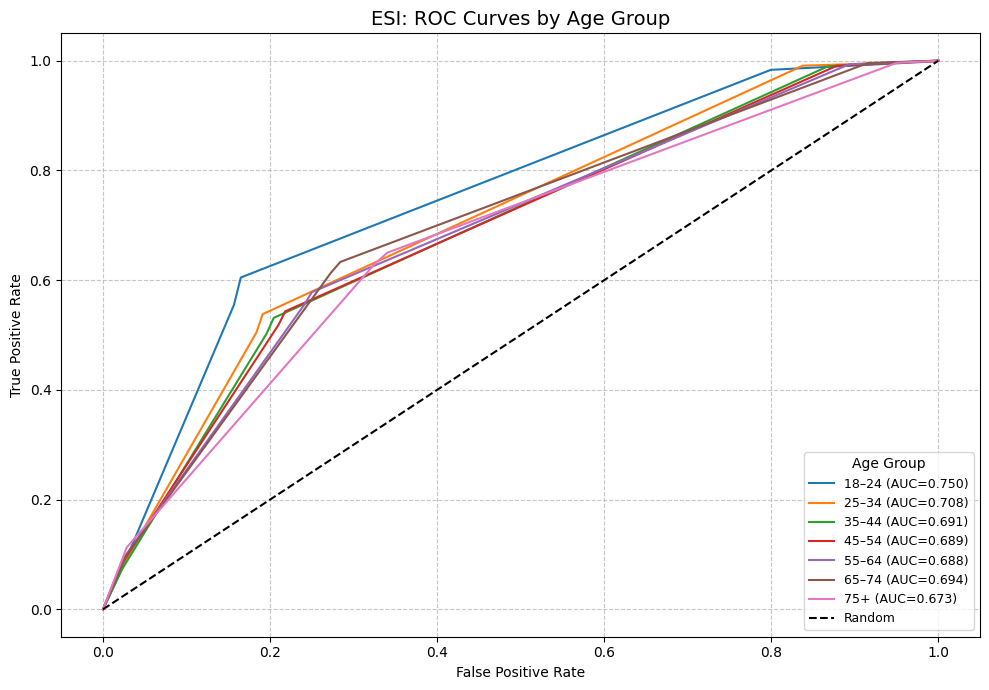

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

age_groups = fair_df_age['age_group'].unique()

plt.figure(figsize=(10, 7))

for group in sorted(age_groups, key=lambda x: age_labels.index(x)):
    group_df = fair_df_age[fair_df_age['age_group'] == group]

    if group_df['y_true'].nunique() < 2:
        print(f"Skipping {group}: only one class present.")
        continue

    fpr, tpr, _ = roc_curve(group_df['y_true'], group_df['y_score'])
    auc = roc_auc_score(group_df['y_true'], group_df['y_score'])

    plt.plot(fpr, tpr, label=f'{group} (AUC={auc:.3f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Plot settings
plt.title('ESI: ROC Curves by Age Group', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Age Group', loc='lower right', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()